<a href="https://colab.research.google.com/github/SantiagoIngeU/Monografia---Identificaci-n-Automatizada-de-Medicamentos-Hom-logos/blob/main/MediSyncMatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [ ]:
!pip install -U google-generativeai

In [ ]:
! pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 64.4 MB/s eta 0:00:00


In [ ]:
! pip install -U sentence-transformers

In [ ]:
# libreria para la eliminiacion de stop words
!pip install pandas nltk

In [ ]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Lectura de la data

In [ ]:
data_bronce = pd.read_csv('/content/drive/MyDrive/Proyecto MediSyncMatch Monografia/Data/DataBronce/DataV2-1.csv')
#data_bronce = pd.read_csv('/content/drive/MyDrive/Proyecto MediSyncMatch Monografia/Data/DataBronce/Data.csv')

In [ ]:
# Numero de registros
data_bronce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5798 entries, 0 to 5797
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   CodigoInterno         5798 non-null   object
 1   NombreInvima          5790 non-null   object
 2   DescripcionComercial  5790 non-null   object
 3   PrincipioActivo       5790 non-null   object
 4   CodigoInvima          5790 non-null   object
 5   Cum                   5790 non-null   object
dtypes: object(6)
memory usage: 271.9+ KB


In [ ]:
data_bronce.shape

(5798, 6)

## Nulos

In [ ]:
#Nulos ?
print("Valores nulos por columna:")
print(data_bronce.isna().sum())

Valores nulos por columna:
CodigoInterno           0
NombreInvima            8
DescripcionComercial    8
PrincipioActivo         8
CodigoInvima            8
Cum                     8
dtype: int64


## Duplicados

In [ ]:
print("\n¿CodigoInterno es único?", data_bronce["CodigoInterno"].is_unique)
print("Duplicados en Cum:", data_bronce["Cum"].duplicated().sum())
print("Duplicados en CodigoInvima:", data_bronce["CodigoInvima"].duplicated().sum())
print("Duplicados en DescripcionComercial:", data_bronce["DescripcionComercial"].duplicated().sum())


¿CodigoInterno es único? False
Duplicados en Cum: 1499
Duplicados en CodigoInvima: 1854
Duplicados en DescripcionComercial: 1615


In [ ]:
data_bronce.columns

Index(['CodigoInterno', 'NombreInvima', 'DescripcionComercial',
       'PrincipioActivo', 'CodigoInvima', 'Cum'],
      dtype='object')

# Transformaciones en la data

## Eliminacion de caracteres especiales, transformacion de caracteres a Mayusculas

In [ ]:
import pandas as pd
import re

def limpiar_texto(df: pd.DataFrame, columnas: list) -> pd.DataFrame:
    """
    Limpia las columnas indicadas del DataFrame eliminando caracteres no alfanuméricos
    y convirtiendo a mayúsculas.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame de entrada.
    columnas : list
        Lista de nombres de columnas a limpiar.

    Retorna
    -------
    pd.DataFrame
        DataFrame con nuevas columnas '_limpio' agregadas.
    """
    for col in columnas:
        if col in df.columns:
            df[f"{col}_limpio"] = (
                df[col]
                .astype(str)
                .str.upper()
                .str.replace(r"[^A-ZÁÉÍÓÚÜÑ0-9\s]", "", regex=True)
            )
        else:
            print(f"⚠️ Advertencia: la columna '{col}' no existe en el DataFrame.")
    return df


In [ ]:
data_bronce["NombreInvima_limpio"] = (
    data_bronce["NombreInvima"]
    .str.upper()
    .str.replace(r"[^A-ZÁÉÍÓÚÜÑ0-9\s]", "", regex=True)
)

data_bronce["DescripcionComercial_limpio"] = (
    data_bronce["DescripcionComercial"]
    .str.upper()
    .str.replace(r"[^A-ZÁÉÍÓÚÜÑ0-9\s]", "", regex=True)
)

data_bronce = data_bronce.drop(["NombreInvima", "DescripcionComercial"], axis=1)
#data_bronce = data_bronce.drop(["NombreInvima", "DescripcionComercial","PrincipioActivo"], axis=1)


In [ ]:
#TODO: Identificando de que los codigos de todos los medicamentos sean codigos unicos
duplicados = data_bronce[data_bronce['CodigoInterno'].duplicated(keep=False)]
#duplicados


In [ ]:
#le asignare una variasion a los codigos internos de estos medicamentos asignandoles '-1' o '-2' con tal d3e identificarlos como valores unicos
data_bronce.loc[
    (data_bronce['Cum'] == '20043928-1') & (data_bronce['CodigoInterno'] == '500722'),
    'CodigoInterno'
] = '500722-1'

In [ ]:
data_bronce.loc[
    (data_bronce['Cum'] == '35578-2') & (data_bronce['CodigoInterno'] == '5321'),
    'CodigoInterno'
] = '5321-1'

In [ ]:
duplicados = data_bronce[data_bronce['CodigoInterno'].duplicated(keep=False)]
#duplicados

## Exploracion semántica

In [ ]:
from collections import Counter
import re

def tokens(text):
    return re.findall(r"\b\w+\b", str(text).lower())


In [ ]:
all_tokens_DescripcionComercial = [t for desc in data_bronce["DescripcionComercial_limpio"] for t in tokens(desc)]
#Counter(all_tokens_DescripcionComercial).most_common(20)

#### Graficando la distribucion de las palabras

In [ ]:

def graficar_distribuciones_de_palabras(all_tokens,nombre_columna):

  top_tokens = Counter(all_tokens).most_common(20)
  palabras, frecuencias = zip(*top_tokens)

  # Crear gráfico
  plt.figure(figsize=(12,6))
  plt.barh(palabras[::-1], frecuencias[::-1], color="steelblue")
  plt.xlabel("Frecuencia")
  plt.ylabel("Término")
  plt.title(f"Top 20 palabras más comunes en {nombre_columna}")
  plt.tight_layout()

  # Guardar en PNG
  plt.savefig(f"/content/drive/MyDrive/Proyecto MediSyncMatch Monografia/Figuras/distibucion_palabras_columna_{nombre_columna}.png", dpi=300)   # alta resolución

  # También puedes guardar en PDF, JPG, SVG, etc.
  # plt.savefig("top20_tokens.pdf")

  plt.show()


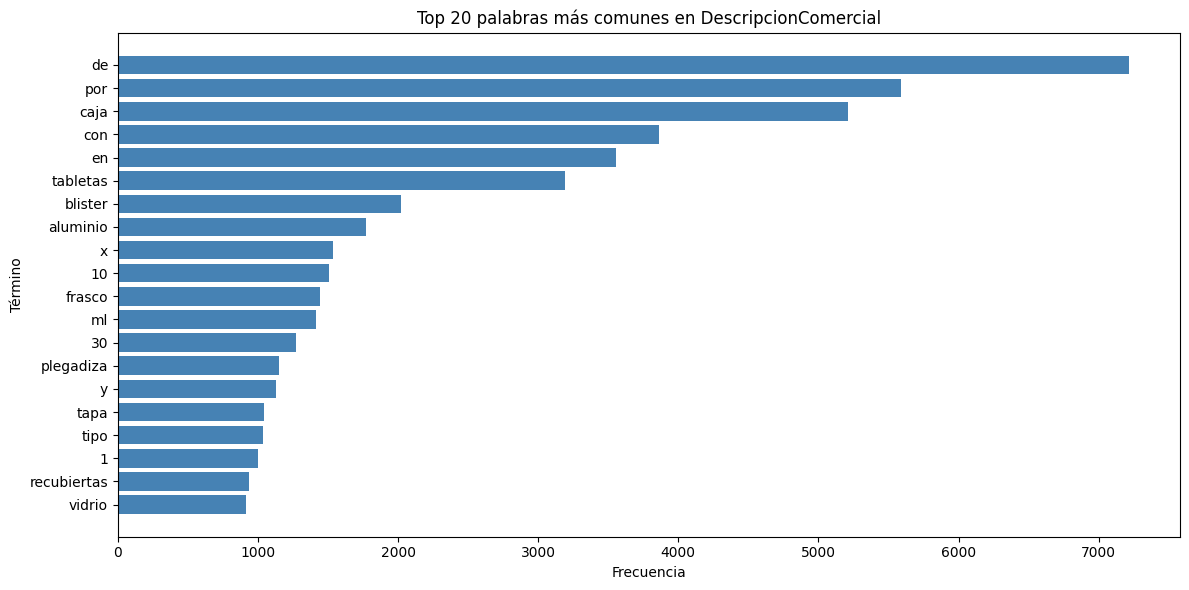

In [ ]:
graficar_distribuciones_de_palabras(all_tokens_DescripcionComercial,"DescripcionComercial")

In [ ]:
all_tokens_NombreInvima_limpio = [t for desc in data_bronce["NombreInvima_limpio"] for t in tokens(desc)]
#Counter(all_tokens_NombreInvima_limpio).most_common(20)

#### Graficando las distribucion de las palabras

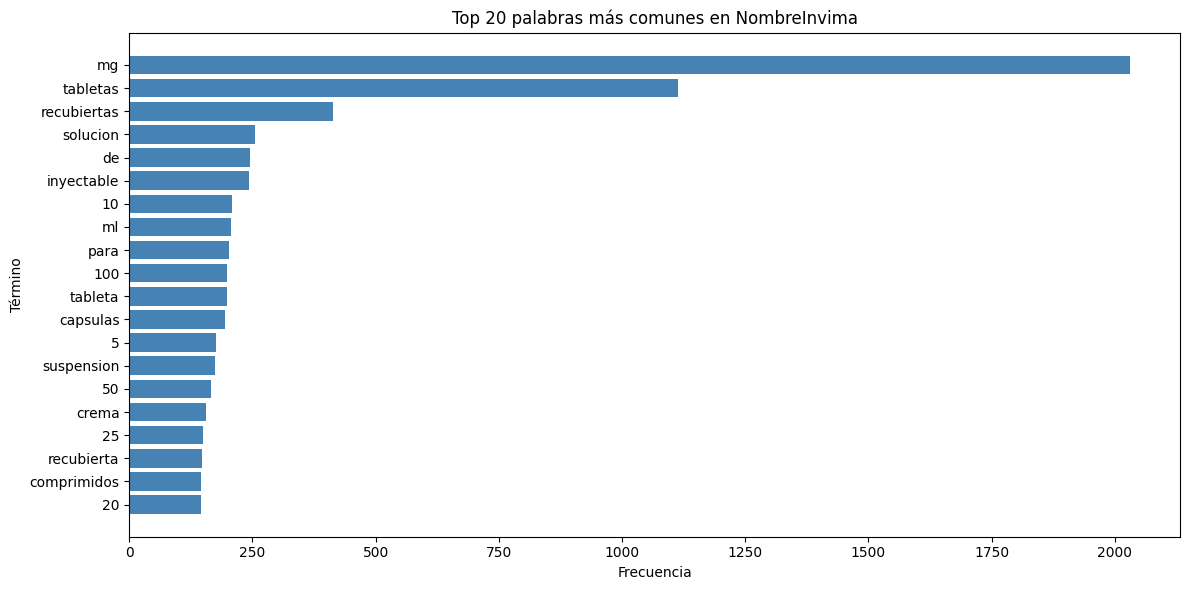

In [ ]:
graficar_distribuciones_de_palabras(all_tokens_NombreInvima_limpio,"NombreInvima")

##Eliminando las stop words y caracteres especiales, eliminarlos en las columnas que no sean Codigo interno

In [ ]:
# instanciando la variable de las stopwords en español
stop_words = set(stopwords.words("spanish"))

In [ ]:
def eliminador_stopwords(texto):
  if not isinstance(texto, str):  # si no es string, devolver vacío o el mismo valor
        return ""
  palabras = texto.lower().split()
  palabras_filtradas = [p for p in palabras if p not in stop_words]
  return " ".join(palabras_filtradas).upper()

In [ ]:
# data bronce despues de la eliminacion de las stop words
data_bronce_sin_stop_words = data_bronce.copy()
data_bronce_sin_stop_words['DescripcionComercial_limpio'] = data_bronce_sin_stop_words['DescripcionComercial_limpio'].apply(eliminador_stopwords)
data_bronce_sin_stop_words['NombreInvima_limpio'] = data_bronce_sin_stop_words['NombreInvima_limpio'].apply(eliminador_stopwords)
#data_bronce_sin_stop_words['PrincipioActivo_limpio'] = data_bronce_sin_stop_words['NombreInvima_limpio'].apply(eliminador_stopwords)

In [ ]:
all_tokens_NombreInvima_limpio = [t for desc in data_bronce_sin_stop_words["NombreInvima_limpio"] for t in tokens(desc)]
#Counter(all_tokens_NombreInvima_limpio).most_common(20)

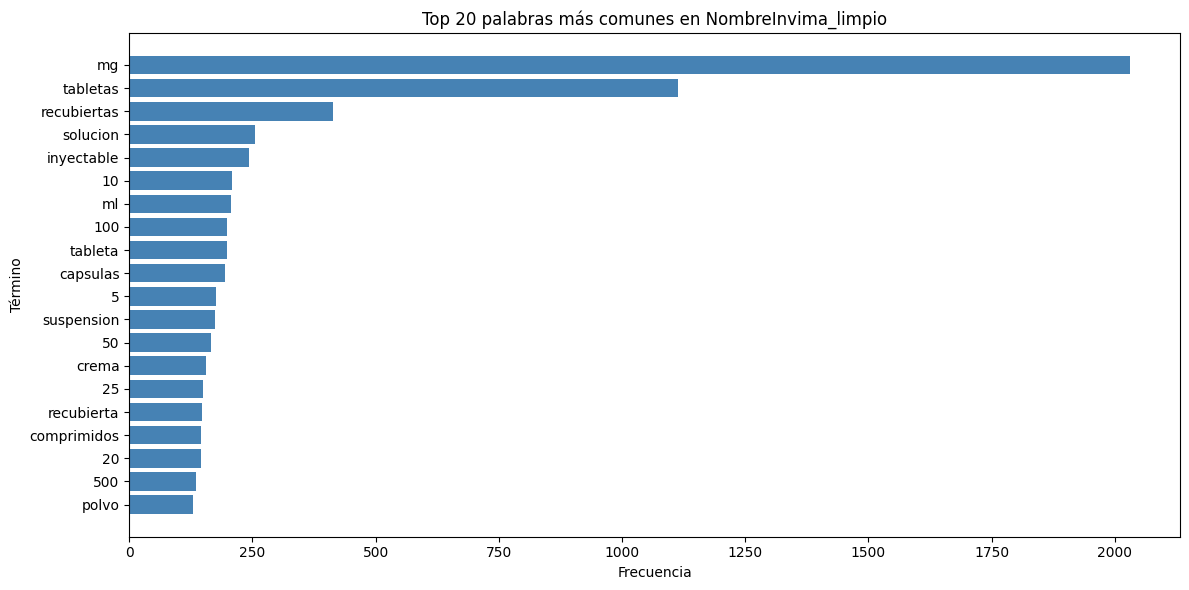

In [ ]:
graficar_distribuciones_de_palabras(all_tokens_NombreInvima_limpio,"NombreInvima_limpio")

In [ ]:
all_tokens_DescripcionComercial = [t for desc in data_bronce_sin_stop_words["DescripcionComercial_limpio"] for t in tokens(desc)]
#Counter(all_tokens_DescripcionComercial).most_common(20)

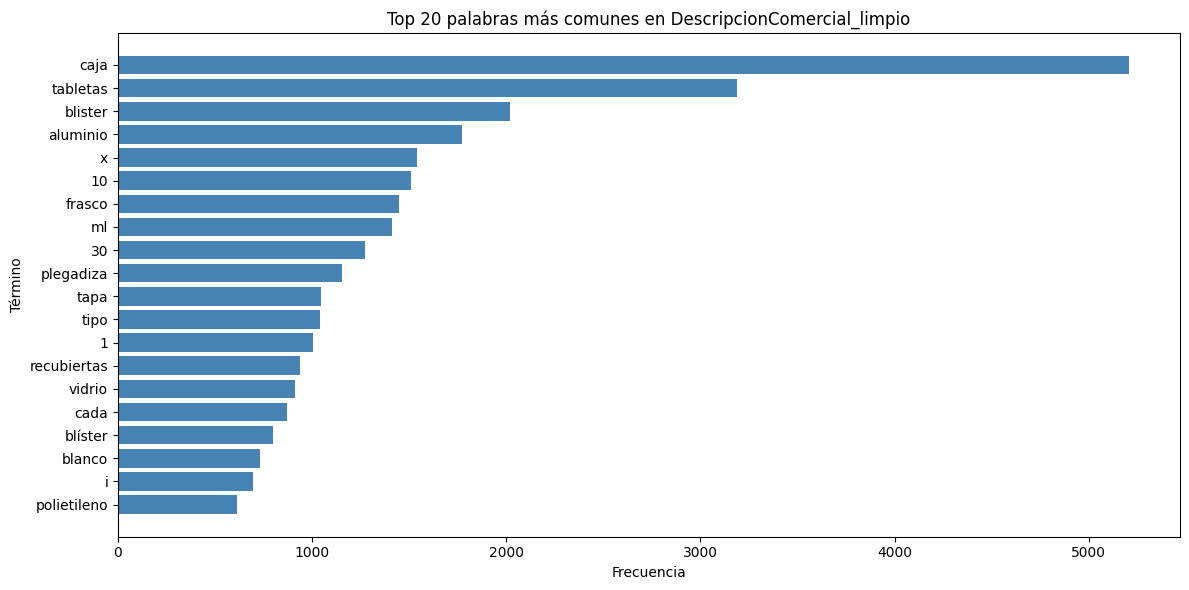

In [ ]:
#TODO: Graficar la exploracion semantica y guardar esta grafica
graficar_distribuciones_de_palabras(all_tokens_DescripcionComercial,"DescripcionComercial_limpio")

### Longitud en los textos

In [ ]:
data_bronce_sin_stop_words.head(1)

,CodigoInterno,PrincipioActivo,CodigoInvima,Cum,NombreInvima_limpio,DescripcionComercial_limpio
0,C005372,LEVOTIROXINA SODICA,INVIMA 2023M-0012120-R2,20027722-13,SYNTHROID 137 MCG,CAJA FRASCO POLIETILENO ALTA DENSIDAD 90 TABLETAS


## Creacion de columna con el documento completo

In [ ]:
def concatenacion_info(df: pd.DataFrame) -> pd.DataFrame:
    """
    Crea una nueva columna 'texto_completo' que concatena la información
    de varias columnas del DataFrame en un solo texto descriptivo.

    Columnas consideradas:
    - CodigoInterno
    - NombreInvima_limpio
    - DescripcionComercial_limpio
    - CodigoInvima
    - Cum

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame con las columnas mencionadas.

    Retorna
    -------
    pd.DataFrame
        Mismo DataFrame con una nueva columna 'texto_completo'.

    Lanza
    -----
    KeyError
        Si falta alguna de las columnas requeridas.
    """

    columnas_requeridas = [
        "CodigoInterno",
        "NombreInvima_limpio",
        "DescripcionComercial_limpio",
        "CodigoInvima",
        "Cum",
        "PrincipioActivo"
    ]

    # Validar existencia de columnas
    faltantes = [col for col in columnas_requeridas if col not in df.columns]
    if faltantes:
        raise KeyError(f"Faltan columnas en el DataFrame: {faltantes}")

    # Concatenar valores tal como estén (si hay NaN, quedarán como 'nan')
    df["texto_completo"] = (
        "Codigo Interno: " + df["CodigoInterno"].astype(str)
        + " | Nombre Invima: " + df["NombreInvima_limpio"].astype(str)
        + " | Descripcion Comercial: " + df["DescripcionComercial_limpio"].astype(str)
        + " | Codigo Invima: " + df["CodigoInvima"].astype(str)
        + " | CUM: " + df["Cum"].astype(str)
        + " | PrincipioActivo: " + df["PrincipioActivo"].astype(str)

    )

    return df

data_bronce_sin_stop_words = concatenacion_info(data_bronce_sin_stop_words)


In [ ]:
data_bronce_sin_stop_words.head(5)

,CodigoInterno,PrincipioActivo,CodigoInvima,Cum,NombreInvima_limpio,DescripcionComercial_limpio,texto_completo
0,C005372,LEVOTIROXINA SODICA,INVIMA 2023M-0012120-R2,20027722-13,SYNTHROID 137 MCG,CAJA FRASCO POLIETILENO ALTA DENSIDAD 90 TABLETAS,Codigo Interno: C005372 | Nombre Invima: SYNTH...
1,C670304,OLMESARTAN MEDOXOMIL,INVIMA 2013M-0014448,20052048-3,ILTUXAM 40 MG 5 MG TABLETAS RECUBIERTAS,CAJA 28 TABLETAS RECUBIERTAS COMPRIMIDOS BLIST...,Codigo Interno: C670304 | Nombre Invima: ILTUX...
2,C150380,BETAMETASONA SODIO FOSFATO 3.95 MGEQUIVALENTE ...,INVIMA 2021M-0009967-R1,20009479-3,INFLACORRETARDINYECTABLE 1 ML,CAJA 100 AMPOLLAS VIDRIO TIPO I INCOLORO 1 ML ...,Codigo Interno: C150380 | Nombre Invima: INFLA...
3,C614002,ERITROPOYETINA RECOMBINANTE HUMANA,INVIMA 2018MBT-0006653-R1,19960160-12,ERITROMAX 4000 UIML,CAJA 25 AMPOLLASSIN DATODE VIDRIO TIPO I TRANS...,Codigo Interno: C614002 | Nombre Invima: ERITR...
4,C265459,DESLORATADINA,INVIMA 2008M-0008131,19985082-1,DESLORATADINA 25 MG 5MLJARABE,CAJA FRASCO PET AMBAR TAPA POLIPROPILENO 60ML,Codigo Interno: C265459 | Nombre Invima: DESLO...


# Creacion de los embedding de la data

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import faiss
import numpy as np
from typing import List

In [ ]:
#PRUEBA 3
import os
import faiss
import pickle
import numpy as np
from typing import List
from sklearn.metrics.pairwise import cosine_similarity
import google.generativeai as genai
from google.colab import userdata

class Embedding:
    def __init__(self, secret_name: str = "GOOGLE_API_KEY"):
        """
        Inicializa el modelo de embeddings y el modelo LLM farmacéutico.
        """
        from sentence_transformers import SentenceTransformer
        self.embedding_model = SentenceTransformer('all-distilroberta-v1') # Con que fue entrenada este modelo
        self.index = faiss.IndexFlatL2(768)
        self.text_store = []
        self.embedding_store = []
        self.threshold = 0.85 #0.80

        api_key = os.getenv(secret_name)
        try:
            if not api_key:
                api_key = userdata.get(secret_name)
        except Exception:
            pass
        if not api_key:
            raise ValueError("❌ No se encontró una clave API válida para Google Gemini.")

        genai.configure(api_key=api_key)
        self.llm_model = "gemini-2.0-flash-exp"

    def embedder(self, textos: List[str]) -> np.ndarray:
        embeddings = self.embedding_model.encode(textos, show_progress_bar=False)
        self.index.add(np.array(embeddings).astype('float32'))
        self.text_store.extend(textos)
        self.embedding_store.extend(embeddings)
        return embeddings

    def embed_single(self, texto: str) -> np.ndarray:
        return self.embedding_model.encode([texto])[0]

    def retrieval(self, query: str, k: int = 5):
        if not self.text_store:
            raise ValueError("El índice está vacío. Ejecuta `.embedder()` primero.")

        query_emb = self.embed_single(query)
        D, I = self.index.search(np.array([query_emb]).astype('float32'), k)

        resultados = []
        for idx, distancia in zip(I[0], D[0]):
            texto = self.text_store[idx]
            emb_candidato = self.embedding_store[idx]
            cos_sim = cosine_similarity([query_emb], [emb_candidato])[0][0]

            if cos_sim >= self.threshold:
                resultados.append({
                    "texto": texto,
                    "distancia_l2": float(distancia),
                    "similitud_coseno": float(cos_sim)
                })
                print(f"🔍 Resultado encontrado correctamente")

        if not resultados:
            print(f"⚠️ Ningún resultado superó el umbral de similitud {self.threshold}.")
        return resultados

    def farmacéutico_llm(self, query: str, k: int = 5) -> dict:
        """
        Usa el modelo LLM (Gemini) para actuar como farmacéutico y recomendar el medicamento homólogo más adecuado.
        """
        top_k = self.retrieval(query, k=k)

        if not top_k:
            return {
                "texto_busqueda": query,
                "top_k": [],
                "respuesta_llm": "No se encontraron candidatos con similitud suficiente."
            }

        contexto = "\n".join([
            f"{i+1}. {item['texto']} (similitud: {item['similitud_coseno']:.3f})"
            for i, item in enumerate(top_k)
        ])

        prompt = f"""
        Eres un farmacéutico experto en homologación de medicamentos.
        Se te proporciona una descripción de búsqueda y una lista de medicamentos candidatos
        que superan un umbral de similitud semántica de {self.threshold}.
        Tu tarea es elegir el medicamento homólogo más adecuado y devolver solo su texto exacto.

        🔍 Texto de búsqueda:
        {query}

        💊 Candidatos filtrados:
        {contexto}

        Respuesta esperada:
        <solo el texto completo del medicamento seleccionado, sin comillas ni explicación>
        """

        model = genai.GenerativeModel(self.llm_model)
        respuesta = model.generate_content(prompt)

        return {
            "texto_busqueda": query,
            "top_k": top_k,
            "respuesta_llm": respuesta.text
        }

    def save_index(self, prefix: str = "embeddings_index"):
        faiss.write_index(self.index, f"{prefix}.faiss")
        with open(f"{prefix}.pkl", "wb") as f:
            pickle.dump({
                "text_store": self.text_store,
                "embedding_store": self.embedding_store
            }, f)
        print(f"Índice y datos guardados con prefijo '{prefix}'")

    def load_index(self, prefix: str = "embeddings_index"):
        self.index = faiss.read_index(f"{prefix}.faiss")
        with open(f"{prefix}.pkl", "rb") as f:
            data = pickle.load(f)
        self.text_store = data["text_store"]
        self.embedding_store = data["embedding_store"]
        print(f"Índice y datos cargados desde '{prefix}'")


In [ ]:

def construir_texto(diccionario: dict) -> str:
    """
    Construye un string con la estructura:
    'Codigo Interno: 320046 | Nombre Invima: DOMPER | ...'
    siguiendo el orden original del diccionario.
    """
    # Crear una lista con los pares clave: valor formateados
    partes = [f"{clave}: {valor}" for clave, valor in diccionario.items()]
    texto_final = " | ".join(partes)
    return texto_final


In [ ]:
codigo_interno = ""
nombre_invima_prueba = "PRINF 750 MG TABLETAS RECUBIERTAS"
descripcion_Comercial = "IUM 1L1003771006100: LEVOFLOXACINO 750.0000 MG TABLETAS DE LIBERACION NO MODIFICADA ORAL (PRINF) TABLETA 1.0000U / CAJA X 5 NA CAJA POR 5 TABLETAS RECUBIERTAS EN UN BLÍSTER DE ALUMINIO PVDC INCOLORO"
principio_activo = ""
codigo_invima = ""
cum = ""

In [ ]:
texto_busqueda = {
    "Codigo Interno":codigo_interno,
    "Nombre Invima":nombre_invima_prueba,
    "Descripcion Comercial":descripcion_Comercial,
    "Principio activo":principio_activo,
    "Codigo Invima":codigo_invima,
    "CUM": cum
}

In [ ]:
query = construir_texto(texto_busqueda)

In [ ]:
emb = Embedding()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
textos = data_bronce_sin_stop_words["texto_completo"].dropna().tolist()

In [ ]:
#print("🧠 Generando embeddings, esto puede tardar un poco...")
#emb.embedder(textos)
#print(f"✅ Embeddings generados para {len(textos)} registros.")

In [ ]:
ruta_indices = "/content/drive/MyDrive/Proyecto MediSyncMatch Monografia/Data/IndicesPlata"
#emb.save_index(prefix=ruta_indices)

In [ ]:
emb.load_index(prefix=ruta_indices)

Índice y datos cargados desde '/content/drive/MyDrive/Proyecto MediSyncMatch Monografia/Data/IndicesPlata'


In [ ]:
resultado = emb.farmacéutico_llm(query=query, k=5)

⚠️ Ningún resultado superó el umbral de similitud 0.85.


In [ ]:
import json

print(json.dumps(resultado, indent=2, ensure_ascii=False))

{
  "texto_busqueda": "Codigo Interno:  | Nombre Invima: PRINF 750 MG TABLETAS RECUBIERTAS | Descripcion Comercial: IUM 1L1003771006100: LEVOFLOXACINO 750.0000 MG TABLETAS DE LIBERACION NO MODIFICADA ORAL (PRINF) TABLETA 1.0000U / CAJA X 5 NA CAJA POR 5 TABLETAS RECUBIERTAS EN UN BLÍSTER DE ALUMINIO PVDC INCOLORO | Principio activo:  | Codigo Invima:  | CUM: ",
  "top_k": [],
  "respuesta_llm": "No se encontraron candidatos con similitud suficiente."
}


# Evaluacion del sistema

In [ ]:
data_bronce_sin_stop_words.head(2)

,CodigoInterno,PrincipioActivo,CodigoInvima,Cum,NombreInvima_limpio,DescripcionComercial_limpio,texto_completo
0,C005372,LEVOTIROXINA SODICA,INVIMA 2023M-0012120-R2,20027722-13,SYNTHROID 137 MCG,CAJA FRASCO POLIETILENO ALTA DENSIDAD 90 TABLETAS,Codigo Interno: C005372 | Nombre Invima: SYNTH...
1,C670304,OLMESARTAN MEDOXOMIL,INVIMA 2013M-0014448,20052048-3,ILTUXAM 40 MG 5 MG TABLETAS RECUBIERTAS,CAJA 28 TABLETAS RECUBIERTAS COMPRIMIDOS BLIST...,Codigo Interno: C670304 | Nombre Invima: ILTUX...


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    data_bronce_sin_stop_words,
    test_size=0.2,
    random_state=42
)

train_texts = train_df["texto_completo"].tolist()
test_texts = test_df["texto_completo"].tolist()

In [ ]:
emb_pruebas = Embedding()
emb_pruebas.embedder(train_texts)
print("Índice FAISS creado con el conjunto de entrenamiento.")

Índice FAISS creado con el conjunto de entrenamiento.


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

resultados = []

for query in tqdm(test_texts, desc="Evaluando retrieval"):
    retrieved = emb_pruebas.retrieval(query, k=5)

    if retrieved:
        similitudes = [r["similitud_coseno"] for r in retrieved]
        promedio = np.mean(similitudes)
        maximo = np.max(similitudes)
        resultados.append({
            "query": query,
            "num_resultados": len(retrieved),
            "similitud_promedio": promedio,
            "similitud_maxima": maximo
        })
    else:
        resultados.append({
            "query": query,
            "num_resultados": 0,
            "similitud_promedio": 0,
            "similitud_maxima": 0
        })

df_resultados = pd.DataFrame(resultados)


Evaluando retrieval:   0%|          | 1/1160 [00:00<07:44,  2.49it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   0%|          | 2/1160 [00:00<06:34,  2.94it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   0%|          | 3/1160 [00:01<06:43,  2.87it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   0%|          | 4/1160 [00:01<08:00,  2.40it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   0%|          | 5/1160 [00:02<08:43,  2.21it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   1%|          | 6/1160 [00:02<08:26,  2.28it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:   1%|          | 7/1160 [00:02<08:08,  2.36it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   1%|          | 8/1160 [00:03<07:33,  2.54it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:   1%|          | 9/1160 [00:03<07:51,  2.44it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   1%|          | 10/1160 [00:03<07:13,  2.66it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   1%|          | 11/1160 [00:04<06:39,  2.88it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   1%|          | 13/1160 [00:04<05:15,  3.64it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:   1%|▏         | 15/1160 [00:05<04:28,  4.26it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   1%|▏         | 17/1160 [00:05<04:11,  4.54it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   2%|▏         | 19/1160 [00:05<03:53,  4.88it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   2%|▏         | 20/1160 [00:06<03:59,  4.76it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   2%|▏         | 21/1160 [00:06<04:14,  4.47it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   2%|▏         | 22/1160 [00:06<04:22,  4.34it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:   2%|▏         | 23/1160 [00:06<04:16,  4.44it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   2%|▏         | 25/1160 [00:07<03:50,  4.92it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   2%|▏         | 26/1160 [00:07<04:17,  4.41it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   2%|▏         | 27/1160 [00:07<04:14,  4.45it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   2%|▏         | 28/1160 [00:07<04:37,  4.07it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   2%|▎         | 29/1160 [00:08<04:35,  4.11it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   3%|▎         | 31/1160 [00:08<04:13,  4.45it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   3%|▎         | 32/1160 [00:08<04:25,  4.25it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   3%|▎         | 34/1160 [00:09<04:06,  4.58it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   3%|▎         | 36/1160 [00:09<03:44,  5.02it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   3%|▎         | 37/1160 [00:09<04:09,  4.49it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   3%|▎         | 39/1160 [00:10<04:42,  3.97it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   3%|▎         | 40/1160 [00:10<04:39,  4.01it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   4%|▎         | 41/1160 [00:10<04:23,  4.24it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   4%|▎         | 43/1160 [00:11<04:11,  4.44it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   4%|▍         | 45/1160 [00:11<03:58,  4.67it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   4%|▍         | 46/1160 [00:12<04:19,  4.29it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   4%|▍         | 47/1160 [00:12<04:13,  4.40it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:   4%|▍         | 48/1160 [00:12<04:14,  4.37it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   4%|▍         | 49/1160 [00:12<04:08,  4.46it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   4%|▍         | 50/1160 [00:12<04:14,  4.36it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:   4%|▍         | 51/1160 [00:13<04:10,  4.43it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   4%|▍         | 52/1160 [00:13<04:13,  4.37it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   5%|▍         | 53/1160 [00:13<04:15,  4.34it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   5%|▍         | 54/1160 [00:13<04:37,  3.99it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   5%|▍         | 55/1160 [00:14<04:51,  3.79it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   5%|▍         | 56/1160 [00:14<05:26,  3.38it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:   5%|▍         | 57/1160 [00:15<07:10,  2.56it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   5%|▌         | 58/1160 [00:15<07:23,  2.48it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   5%|▌         | 59/1160 [00:16<07:28,  2.45it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   5%|▌         | 60/1160 [00:16<08:56,  2.05it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   5%|▌         | 61/1160 [00:17<08:03,  2.27it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:   5%|▌         | 62/1160 [00:17<07:36,  2.41it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   6%|▌         | 64/1160 [00:17<05:39,  3.22it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   6%|▌         | 66/1160 [00:18<04:52,  3.74it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   6%|▌         | 68/1160 [00:18<04:45,  3.83it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   6%|▌         | 70/1160 [00:19<04:10,  4.36it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   6%|▌         | 71/1160 [00:19<04:08,  4.38it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   6%|▋         | 73/1160 [00:19<03:57,  4.59it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   6%|▋         | 75/1160 [00:20<03:45,  4.82it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   7%|▋         | 77/1160 [00:20<04:03,  4.45it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   7%|▋         | 78/1160 [00:21<03:55,  4.60it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   7%|▋         | 79/1160 [00:21<04:14,  4.25it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   7%|▋         | 81/1160 [00:21<03:57,  4.54it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   7%|▋         | 83/1160 [00:22<03:43,  4.83it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   7%|▋         | 84/1160 [00:22<03:41,  4.87it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   7%|▋         | 86/1160 [00:22<03:51,  4.63it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   8%|▊         | 88/1160 [00:23<03:52,  4.61it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   8%|▊         | 89/1160 [00:23<03:43,  4.80it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   8%|▊         | 90/1160 [00:23<04:04,  4.38it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   8%|▊         | 91/1160 [00:23<04:16,  4.17it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   8%|▊         | 93/1160 [00:24<03:54,  4.55it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   8%|▊         | 94/1160 [00:24<04:11,  4.24it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   8%|▊         | 96/1160 [00:25<04:06,  4.31it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:   8%|▊         | 97/1160 [00:25<04:24,  4.02it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   8%|▊         | 98/1160 [00:25<04:22,  4.04it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   9%|▊         | 99/1160 [00:25<04:11,  4.22it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   9%|▊         | 101/1160 [00:26<03:52,  4.55it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   9%|▉         | 102/1160 [00:26<03:41,  4.78it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   9%|▉         | 103/1160 [00:26<03:57,  4.45it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   9%|▉         | 105/1160 [00:27<03:40,  4.77it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   9%|▉         | 107/1160 [00:27<03:39,  4.80it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   9%|▉         | 108/1160 [00:27<03:56,  4.45it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:   9%|▉         | 109/1160 [00:28<05:13,  3.35it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:   9%|▉         | 110/1160 [00:28<05:13,  3.35it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  10%|▉         | 111/1160 [00:29<05:52,  2.97it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  10%|▉         | 112/1160 [00:29<06:06,  2.86it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  10%|▉         | 113/1160 [00:29<05:47,  3.02it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  10%|▉         | 114/1160 [00:30<06:07,  2.85it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  10%|▉         | 115/1160 [00:30<05:48,  2.99it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  10%|█         | 116/1160 [00:30<07:19,  2.38it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  10%|█         | 117/1160 [00:31<06:39,  2.61it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  10%|█         | 118/1160 [00:31<06:52,  2.52it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  10%|█         | 119/1160 [00:31<05:52,  2.96it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  10%|█         | 120/1160 [00:32<05:14,  3.30it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  10%|█         | 121/1160 [00:32<04:45,  3.64it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  11%|█         | 122/1160 [00:32<04:31,  3.83it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  11%|█         | 123/1160 [00:32<04:17,  4.03it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  11%|█         | 124/1160 [00:33<04:24,  3.92it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  11%|█         | 126/1160 [00:33<04:15,  4.04it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  11%|█         | 128/1160 [00:33<03:45,  4.57it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  11%|█         | 130/1160 [00:34<03:36,  4.76it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  11%|█▏        | 132/1160 [00:34<03:51,  4.43it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  11%|█▏        | 133/1160 [00:35<03:44,  4.57it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  12%|█▏        | 134/1160 [00:35<03:46,  4.52it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  12%|█▏        | 135/1160 [00:35<03:47,  4.51it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  12%|█▏        | 136/1160 [00:35<04:12,  4.06it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  12%|█▏        | 137/1160 [00:36<03:59,  4.27it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  12%|█▏        | 138/1160 [00:36<03:51,  4.41it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  12%|█▏        | 139/1160 [00:36<03:59,  4.26it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  12%|█▏        | 141/1160 [00:36<03:45,  4.52it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  12%|█▏        | 142/1160 [00:37<03:54,  4.34it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  12%|█▏        | 143/1160 [00:37<03:50,  4.42it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  12%|█▎        | 145/1160 [00:37<03:36,  4.69it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  13%|█▎        | 147/1160 [00:38<03:29,  4.83it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  13%|█▎        | 149/1160 [00:38<03:36,  4.66it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  13%|█▎        | 150/1160 [00:38<03:29,  4.81it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  13%|█▎        | 152/1160 [00:39<03:27,  4.85it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  13%|█▎        | 154/1160 [00:39<03:48,  4.41it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  13%|█▎        | 156/1160 [00:40<03:34,  4.68it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  14%|█▎        | 157/1160 [00:40<03:33,  4.71it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  14%|█▎        | 159/1160 [00:40<03:25,  4.87it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  14%|█▍        | 161/1160 [00:41<03:21,  4.96it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  14%|█▍        | 163/1160 [00:41<03:19,  4.99it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  14%|█▍        | 164/1160 [00:41<04:02,  4.10it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  14%|█▍        | 165/1160 [00:42<04:10,  3.97it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  14%|█▍        | 166/1160 [00:42<04:52,  3.40it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  14%|█▍        | 167/1160 [00:42<05:05,  3.25it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  14%|█▍        | 168/1160 [00:43<05:00,  3.30it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  15%|█▍        | 169/1160 [00:43<05:06,  3.23it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  15%|█▍        | 170/1160 [00:43<05:30,  3.00it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  15%|█▍        | 171/1160 [00:44<05:50,  2.82it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  15%|█▍        | 172/1160 [00:44<05:57,  2.76it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  15%|█▍        | 173/1160 [00:45<06:18,  2.60it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  15%|█▌        | 174/1160 [00:45<05:52,  2.80it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  15%|█▌        | 176/1160 [00:45<04:43,  3.47it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  15%|█▌        | 178/1160 [00:46<03:57,  4.13it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  16%|█▌        | 180/1160 [00:46<03:51,  4.23it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  16%|█▌        | 182/1160 [00:47<03:41,  4.42it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  16%|█▌        | 184/1160 [00:47<03:18,  4.92it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  16%|█▌        | 185/1160 [00:47<03:38,  4.46it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  16%|█▌        | 187/1160 [00:48<03:25,  4.74it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  16%|█▌        | 188/1160 [00:48<03:13,  5.02it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  16%|█▋        | 189/1160 [00:48<03:26,  4.70it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  16%|█▋        | 190/1160 [00:49<03:46,  4.29it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  17%|█▋        | 192/1160 [00:49<03:23,  4.76it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  17%|█▋        | 193/1160 [00:49<03:15,  4.93it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  17%|█▋        | 194/1160 [00:49<04:03,  3.97it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  17%|█▋        | 195/1160 [00:50<03:58,  4.05it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  17%|█▋        | 196/1160 [00:50<04:08,  3.88it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  17%|█▋        | 197/1160 [00:50<04:00,  4.00it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  17%|█▋        | 198/1160 [00:51<04:38,  3.45it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  17%|█▋        | 200/1160 [00:51<03:57,  4.05it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  17%|█▋        | 202/1160 [00:51<03:21,  4.76it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  18%|█▊        | 203/1160 [00:52<03:21,  4.74it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  18%|█▊        | 204/1160 [00:52<03:24,  4.69it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  18%|█▊        | 205/1160 [00:52<03:31,  4.52it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  18%|█▊        | 207/1160 [00:52<03:26,  4.61it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  18%|█▊        | 208/1160 [00:53<03:34,  4.44it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  18%|█▊        | 210/1160 [00:53<03:21,  4.70it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  18%|█▊        | 212/1160 [00:54<03:08,  5.03it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  18%|█▊        | 213/1160 [00:54<03:10,  4.98it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  18%|█▊        | 214/1160 [00:54<03:23,  4.65it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  19%|█▊        | 216/1160 [00:54<03:26,  4.56it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  19%|█▊        | 217/1160 [00:55<03:14,  4.84it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  19%|█▉        | 219/1160 [00:55<03:15,  4.82it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  19%|█▉        | 220/1160 [00:55<03:38,  4.30it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  19%|█▉        | 221/1160 [00:56<04:19,  3.61it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  19%|█▉        | 222/1160 [00:56<04:50,  3.22it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  19%|█▉        | 223/1160 [00:56<04:38,  3.37it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  19%|█▉        | 224/1160 [00:57<04:39,  3.35it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  19%|█▉        | 225/1160 [00:57<05:18,  2.94it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  19%|█▉        | 226/1160 [00:57<05:19,  2.93it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  20%|█▉        | 227/1160 [00:58<05:02,  3.09it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  20%|█▉        | 228/1160 [00:58<05:06,  3.04it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  20%|█▉        | 229/1160 [00:58<05:05,  3.05it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  20%|█▉        | 230/1160 [00:59<05:24,  2.87it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  20%|█▉        | 231/1160 [00:59<05:08,  3.02it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  20%|██        | 233/1160 [01:00<04:14,  3.65it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  20%|██        | 234/1160 [01:00<04:00,  3.85it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  20%|██        | 236/1160 [01:00<03:41,  4.17it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  21%|██        | 238/1160 [01:01<03:35,  4.28it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  21%|██        | 240/1160 [01:01<03:11,  4.80it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  21%|██        | 241/1160 [01:01<03:15,  4.70it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  21%|██        | 242/1160 [01:02<03:24,  4.49it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  21%|██        | 244/1160 [01:02<03:22,  4.52it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  21%|██        | 246/1160 [01:02<03:14,  4.71it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  21%|██▏       | 247/1160 [01:03<03:24,  4.46it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  21%|██▏       | 248/1160 [01:03<03:25,  4.43it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  21%|██▏       | 249/1160 [01:03<03:20,  4.53it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  22%|██▏       | 250/1160 [01:03<03:29,  4.35it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  22%|██▏       | 251/1160 [01:04<03:25,  4.41it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  22%|██▏       | 253/1160 [01:04<03:08,  4.81it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  22%|██▏       | 254/1160 [01:04<03:03,  4.94it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  22%|██▏       | 255/1160 [01:04<03:08,  4.80it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  22%|██▏       | 257/1160 [01:05<03:04,  4.90it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  22%|██▏       | 258/1160 [01:05<02:59,  5.02it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  22%|██▏       | 259/1160 [01:05<03:14,  4.64it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  22%|██▎       | 261/1160 [01:06<03:07,  4.79it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  23%|██▎       | 263/1160 [01:06<03:05,  4.85it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  23%|██▎       | 264/1160 [01:06<03:17,  4.54it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  23%|██▎       | 265/1160 [01:06<03:12,  4.64it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  23%|██▎       | 267/1160 [01:07<03:32,  4.21it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  23%|██▎       | 268/1160 [01:07<03:32,  4.20it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  23%|██▎       | 269/1160 [01:07<03:32,  4.19it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  23%|██▎       | 271/1160 [01:08<03:09,  4.68it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  23%|██▎       | 272/1160 [01:08<03:30,  4.22it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  24%|██▎       | 273/1160 [01:08<03:31,  4.19it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  24%|██▎       | 274/1160 [01:09<03:27,  4.28it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  24%|██▎       | 275/1160 [01:09<03:27,  4.27it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  24%|██▍       | 276/1160 [01:09<03:37,  4.06it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  24%|██▍       | 277/1160 [01:10<04:08,  3.55it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  24%|██▍       | 278/1160 [01:10<04:24,  3.34it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  24%|██▍       | 279/1160 [01:10<04:21,  3.37it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  24%|██▍       | 280/1160 [01:11<04:46,  3.07it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  24%|██▍       | 281/1160 [01:11<04:53,  2.99it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  24%|██▍       | 282/1160 [01:11<05:20,  2.74it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  24%|██▍       | 283/1160 [01:12<05:27,  2.68it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  24%|██▍       | 284/1160 [01:12<05:12,  2.80it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  25%|██▍       | 285/1160 [01:12<05:03,  2.88it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  25%|██▍       | 286/1160 [01:13<05:12,  2.79it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  25%|██▍       | 288/1160 [01:13<04:28,  3.24it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  25%|██▍       | 289/1160 [01:14<04:14,  3.42it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  25%|██▌       | 291/1160 [01:14<03:37,  3.99it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  25%|██▌       | 292/1160 [01:14<03:38,  3.98it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  25%|██▌       | 293/1160 [01:14<03:29,  4.14it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  25%|██▌       | 294/1160 [01:15<03:19,  4.33it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  25%|██▌       | 295/1160 [01:15<03:34,  4.03it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  26%|██▌       | 296/1160 [01:15<03:24,  4.22it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  26%|██▌       | 297/1160 [01:15<03:29,  4.13it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  26%|██▌       | 299/1160 [01:16<03:10,  4.52it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  26%|██▌       | 300/1160 [01:16<02:55,  4.91it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  26%|██▌       | 301/1160 [01:16<03:03,  4.68it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  26%|██▌       | 302/1160 [01:16<03:04,  4.66it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  26%|██▌       | 303/1160 [01:17<03:15,  4.38it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  26%|██▋       | 305/1160 [01:17<03:06,  4.58it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  26%|██▋       | 307/1160 [01:18<02:55,  4.87it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  27%|██▋       | 308/1160 [01:18<03:20,  4.25it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  27%|██▋       | 310/1160 [01:18<03:05,  4.58it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  27%|██▋       | 311/1160 [01:18<03:03,  4.63it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  27%|██▋       | 312/1160 [01:19<03:32,  3.98it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  27%|██▋       | 313/1160 [01:19<03:46,  3.75it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  27%|██▋       | 314/1160 [01:19<03:35,  3.93it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  27%|██▋       | 315/1160 [01:20<03:27,  4.08it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  27%|██▋       | 316/1160 [01:20<03:43,  3.77it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  27%|██▋       | 317/1160 [01:20<03:56,  3.56it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  28%|██▊       | 319/1160 [01:21<03:30,  4.00it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  28%|██▊       | 320/1160 [01:21<03:10,  4.40it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  28%|██▊       | 321/1160 [01:21<03:13,  4.35it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  28%|██▊       | 323/1160 [01:21<03:03,  4.57it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  28%|██▊       | 325/1160 [01:22<02:54,  4.78it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  28%|██▊       | 326/1160 [01:22<03:00,  4.61it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  28%|██▊       | 327/1160 [01:22<03:03,  4.55it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  28%|██▊       | 328/1160 [01:23<03:07,  4.43it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  28%|██▊       | 329/1160 [01:23<03:03,  4.54it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  28%|██▊       | 330/1160 [01:23<02:58,  4.64it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  29%|██▊       | 331/1160 [01:23<03:23,  4.08it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  29%|██▊       | 332/1160 [01:24<03:58,  3.46it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  29%|██▊       | 333/1160 [01:24<04:09,  3.31it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  29%|██▉       | 334/1160 [01:24<04:34,  3.01it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  29%|██▉       | 335/1160 [01:25<04:32,  3.03it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  29%|██▉       | 336/1160 [01:25<04:44,  2.89it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  29%|██▉       | 337/1160 [01:26<04:55,  2.79it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  29%|██▉       | 338/1160 [01:26<04:55,  2.78it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  29%|██▉       | 339/1160 [01:26<04:30,  3.04it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  29%|██▉       | 340/1160 [01:26<04:37,  2.95it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  29%|██▉       | 341/1160 [01:27<04:59,  2.74it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  30%|██▉       | 343/1160 [01:27<04:09,  3.27it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  30%|██▉       | 345/1160 [01:28<03:27,  3.93it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  30%|██▉       | 346/1160 [01:28<03:38,  3.73it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  30%|███       | 348/1160 [01:29<03:39,  3.70it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  30%|███       | 349/1160 [01:29<03:23,  3.99it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  30%|███       | 350/1160 [01:29<03:39,  3.69it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  30%|███       | 352/1160 [01:30<03:21,  4.02it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  31%|███       | 354/1160 [01:30<03:07,  4.30it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  31%|███       | 355/1160 [01:30<03:18,  4.05it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  31%|███       | 356/1160 [01:31<03:40,  3.65it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  31%|███       | 358/1160 [01:31<03:07,  4.28it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  31%|███       | 359/1160 [01:31<02:52,  4.64it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  31%|███       | 360/1160 [01:32<02:53,  4.60it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  31%|███       | 361/1160 [01:32<02:59,  4.46it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  31%|███       | 362/1160 [01:32<03:09,  4.22it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  31%|███▏      | 363/1160 [01:32<03:02,  4.37it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  31%|███▏      | 364/1160 [01:32<03:01,  4.40it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  31%|███▏      | 365/1160 [01:33<03:06,  4.26it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  32%|███▏      | 366/1160 [01:33<03:00,  4.39it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  32%|███▏      | 367/1160 [01:33<03:03,  4.33it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  32%|███▏      | 369/1160 [01:34<02:48,  4.70it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  32%|███▏      | 370/1160 [01:34<02:45,  4.77it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  32%|███▏      | 372/1160 [01:34<02:37,  5.00it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  32%|███▏      | 374/1160 [01:35<02:24,  5.44it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente


Evaluando retrieval:  32%|███▏      | 376/1160 [01:35<02:31,  5.19it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  32%|███▎      | 377/1160 [01:35<02:25,  5.37it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  33%|███▎      | 378/1160 [01:35<02:38,  4.95it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  33%|███▎      | 380/1160 [01:36<02:40,  4.87it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  33%|███▎      | 382/1160 [01:36<02:35,  5.01it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  33%|███▎      | 383/1160 [01:36<02:44,  4.74it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  33%|███▎      | 385/1160 [01:37<02:40,  4.82it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente


Evaluando retrieval:  33%|███▎      | 386/1160 [01:37<02:44,  4.71it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  33%|███▎      | 387/1160 [01:37<02:56,  4.38it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  33%|███▎      | 388/1160 [01:38<03:25,  3.75it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  34%|███▎      | 389/1160 [01:38<03:45,  3.42it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  34%|███▎      | 390/1160 [01:38<03:55,  3.27it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  34%|███▎      | 391/1160 [01:39<04:02,  3.18it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  34%|███▍      | 392/1160 [01:39<04:11,  3.06it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  34%|███▍      | 393/1160 [01:39<04:35,  2.78it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  34%|███▍      | 394/1160 [01:40<05:03,  2.52it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  34%|███▍      | 395/1160 [01:40<05:18,  2.40it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  34%|███▍      | 396/1160 [01:41<05:00,  2.54it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  34%|███▍      | 397/1160 [01:41<04:35,  2.77it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  34%|███▍      | 398/1160 [01:41<04:05,  3.11it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  34%|███▍      | 400/1160 [01:42<03:16,  3.87it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  35%|███▍      | 402/1160 [01:42<02:55,  4.33it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  35%|███▍      | 403/1160 [01:42<02:42,  4.66it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  35%|███▌      | 406/1160 [01:43<02:28,  5.08it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  35%|███▌      | 408/1160 [01:43<02:24,  5.21it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  35%|███▌      | 409/1160 [01:43<02:22,  5.26it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  35%|███▌      | 411/1160 [01:44<02:22,  5.26it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  36%|███▌      | 412/1160 [01:44<02:41,  4.62it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  36%|███▌      | 413/1160 [01:44<02:44,  4.53it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  36%|███▌      | 415/1160 [01:45<02:35,  4.78it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  36%|███▌      | 416/1160 [01:45<02:43,  4.56it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  36%|███▌      | 418/1160 [01:45<02:36,  4.74it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  36%|███▌      | 419/1160 [01:46<02:36,  4.73it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  36%|███▌      | 420/1160 [01:46<02:42,  4.54it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  36%|███▋      | 421/1160 [01:46<02:54,  4.25it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  36%|███▋      | 423/1160 [01:46<02:40,  4.59it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  37%|███▋      | 424/1160 [01:47<02:43,  4.51it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  37%|███▋      | 425/1160 [01:47<03:01,  4.06it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  37%|███▋      | 427/1160 [01:47<02:42,  4.52it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  37%|███▋      | 429/1160 [01:48<02:38,  4.61it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  37%|███▋      | 431/1160 [01:48<02:32,  4.77it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  37%|███▋      | 432/1160 [01:49<02:44,  4.42it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  37%|███▋      | 434/1160 [01:49<02:30,  4.82it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  38%|███▊      | 436/1160 [01:49<02:23,  5.05it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  38%|███▊      | 437/1160 [01:50<02:40,  4.51it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  38%|███▊      | 438/1160 [01:50<02:37,  4.58it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  38%|███▊      | 440/1160 [01:50<02:44,  4.38it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  38%|███▊      | 441/1160 [01:51<02:47,  4.30it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  38%|███▊      | 443/1160 [01:51<02:49,  4.24it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  38%|███▊      | 444/1160 [01:51<02:54,  4.11it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  38%|███▊      | 445/1160 [01:52<03:10,  3.76it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  38%|███▊      | 446/1160 [01:52<03:27,  3.45it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  39%|███▊      | 447/1160 [01:52<03:44,  3.18it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  39%|███▊      | 448/1160 [01:53<03:29,  3.40it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  39%|███▊      | 449/1160 [01:53<03:39,  3.23it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  39%|███▉      | 450/1160 [01:53<03:58,  2.97it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  39%|███▉      | 451/1160 [01:54<04:02,  2.92it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  39%|███▉      | 452/1160 [01:54<04:15,  2.77it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  39%|███▉      | 453/1160 [01:54<04:18,  2.74it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  39%|███▉      | 454/1160 [01:55<04:32,  2.59it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  39%|███▉      | 455/1160 [01:55<04:34,  2.57it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  39%|███▉      | 456/1160 [01:55<04:00,  2.93it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  39%|███▉      | 457/1160 [01:56<03:35,  3.27it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  39%|███▉      | 458/1160 [01:56<03:16,  3.58it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  40%|███▉      | 459/1160 [01:56<03:19,  3.51it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  40%|███▉      | 460/1160 [01:56<03:14,  3.60it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  40%|███▉      | 461/1160 [01:57<03:14,  3.60it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  40%|███▉      | 462/1160 [01:57<02:58,  3.91it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  40%|███▉      | 463/1160 [01:57<03:07,  3.71it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  40%|████      | 465/1160 [01:58<02:43,  4.25it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  40%|████      | 466/1160 [01:58<02:55,  3.96it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  40%|████      | 468/1160 [01:58<02:49,  4.09it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  40%|████      | 469/1160 [01:59<02:36,  4.41it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  41%|████      | 470/1160 [01:59<02:33,  4.50it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  41%|████      | 471/1160 [01:59<02:33,  4.50it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  41%|████      | 473/1160 [02:00<02:26,  4.70it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  41%|████      | 475/1160 [02:00<02:23,  4.76it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  41%|████      | 476/1160 [02:00<02:23,  4.77it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  41%|████      | 478/1160 [02:01<02:20,  4.86it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  41%|████▏     | 480/1160 [02:01<02:24,  4.71it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  41%|████▏     | 481/1160 [02:01<02:21,  4.79it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  42%|████▏     | 482/1160 [02:01<02:21,  4.79it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  42%|████▏     | 483/1160 [02:02<02:39,  4.24it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  42%|████▏     | 484/1160 [02:02<02:35,  4.35it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  42%|████▏     | 485/1160 [02:02<02:34,  4.38it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  42%|████▏     | 487/1160 [02:03<02:57,  3.79it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  42%|████▏     | 490/1160 [02:03<02:23,  4.67it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  42%|████▏     | 492/1160 [02:04<02:11,  5.10it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  43%|████▎     | 494/1160 [02:04<02:17,  4.84it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  43%|████▎     | 495/1160 [02:04<02:12,  5.03it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  43%|████▎     | 496/1160 [02:05<02:24,  4.60it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  43%|████▎     | 497/1160 [02:05<02:28,  4.47it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  43%|████▎     | 498/1160 [02:05<02:46,  3.98it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  43%|████▎     | 499/1160 [02:05<02:36,  4.21it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  43%|████▎     | 500/1160 [02:06<03:26,  3.20it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  43%|████▎     | 501/1160 [02:06<03:43,  2.95it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  43%|████▎     | 502/1160 [02:07<04:04,  2.69it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  43%|████▎     | 503/1160 [02:07<04:13,  2.59it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  43%|████▎     | 504/1160 [02:07<03:55,  2.79it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  44%|████▎     | 505/1160 [02:08<03:48,  2.87it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  44%|████▎     | 506/1160 [02:08<04:20,  2.51it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  44%|████▎     | 507/1160 [02:09<04:07,  2.64it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  44%|████▍     | 508/1160 [02:09<03:57,  2.75it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  44%|████▍     | 509/1160 [02:09<04:23,  2.47it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  44%|████▍     | 511/1160 [02:10<03:12,  3.37it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  44%|████▍     | 512/1160 [02:10<02:53,  3.74it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  44%|████▍     | 513/1160 [02:10<02:47,  3.86it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  44%|████▍     | 515/1160 [02:11<02:33,  4.20it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  44%|████▍     | 516/1160 [02:11<02:30,  4.27it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  45%|████▍     | 518/1160 [02:11<02:26,  4.38it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  45%|████▍     | 519/1160 [02:12<02:23,  4.47it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  45%|████▍     | 520/1160 [02:12<02:20,  4.56it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  45%|████▌     | 522/1160 [02:12<02:16,  4.67it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  45%|████▌     | 523/1160 [02:12<02:10,  4.87it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  45%|████▌     | 524/1160 [02:13<02:14,  4.73it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  45%|████▌     | 525/1160 [02:13<02:18,  4.59it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  45%|████▌     | 526/1160 [02:13<02:18,  4.59it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  45%|████▌     | 527/1160 [02:13<02:20,  4.49it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  46%|████▌     | 528/1160 [02:13<02:20,  4.50it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  46%|████▌     | 530/1160 [02:14<02:18,  4.54it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  46%|████▌     | 531/1160 [02:14<02:22,  4.40it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  46%|████▌     | 534/1160 [02:15<02:16,  4.59it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  46%|████▌     | 535/1160 [02:15<02:14,  4.63it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  46%|████▌     | 536/1160 [02:15<02:22,  4.37it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  46%|████▋     | 537/1160 [02:16<02:36,  3.99it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  46%|████▋     | 538/1160 [02:16<02:53,  3.58it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  47%|████▋     | 540/1160 [02:16<02:35,  3.98it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  47%|████▋     | 542/1160 [02:17<02:25,  4.25it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  47%|████▋     | 543/1160 [02:17<02:44,  3.76it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  47%|████▋     | 544/1160 [02:18<02:48,  3.66it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  47%|████▋     | 545/1160 [02:18<02:36,  3.94it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  47%|████▋     | 546/1160 [02:18<02:28,  4.14it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  47%|████▋     | 547/1160 [02:18<02:34,  3.96it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  47%|████▋     | 549/1160 [02:19<02:18,  4.40it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  48%|████▊     | 551/1160 [02:19<02:00,  5.04it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  48%|████▊     | 552/1160 [02:19<02:02,  4.97it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  48%|████▊     | 553/1160 [02:19<02:05,  4.85it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  48%|████▊     | 554/1160 [02:20<02:29,  4.06it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  48%|████▊     | 555/1160 [02:20<02:47,  3.62it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  48%|████▊     | 556/1160 [02:20<02:49,  3.57it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  48%|████▊     | 557/1160 [02:21<03:00,  3.35it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  48%|████▊     | 558/1160 [02:21<03:03,  3.29it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  48%|████▊     | 559/1160 [02:21<03:03,  3.28it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  48%|████▊     | 560/1160 [02:22<02:56,  3.40it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  48%|████▊     | 561/1160 [02:22<03:05,  3.23it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  48%|████▊     | 562/1160 [02:22<03:22,  2.96it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  49%|████▊     | 563/1160 [02:23<03:39,  2.72it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  49%|████▊     | 564/1160 [02:23<03:45,  2.64it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  49%|████▊     | 565/1160 [02:24<03:33,  2.78it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  49%|████▉     | 566/1160 [02:24<03:18,  2.99it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  49%|████▉     | 568/1160 [02:24<02:41,  3.67it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  49%|████▉     | 569/1160 [02:24<02:30,  3.92it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  49%|████▉     | 570/1160 [02:25<02:27,  3.99it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  49%|████▉     | 571/1160 [02:25<02:20,  4.20it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  49%|████▉     | 572/1160 [02:25<02:17,  4.26it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  49%|████▉     | 573/1160 [02:25<02:19,  4.21it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  49%|████▉     | 574/1160 [02:26<02:19,  4.21it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  50%|████▉     | 576/1160 [02:26<02:11,  4.44it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  50%|████▉     | 577/1160 [02:26<02:10,  4.48it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  50%|████▉     | 579/1160 [02:27<02:04,  4.66it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  50%|█████     | 580/1160 [02:27<02:16,  4.24it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  50%|█████     | 582/1160 [02:27<02:16,  4.23it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  50%|█████     | 583/1160 [02:28<02:09,  4.46it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  50%|█████     | 584/1160 [02:28<02:06,  4.56it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  50%|█████     | 585/1160 [02:28<02:04,  4.63it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  51%|█████     | 586/1160 [02:28<02:15,  4.23it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  51%|█████     | 587/1160 [02:29<02:13,  4.30it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  51%|█████     | 588/1160 [02:29<02:22,  4.01it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  51%|█████     | 589/1160 [02:29<02:16,  4.19it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  51%|█████     | 590/1160 [02:29<02:10,  4.35it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  51%|█████     | 592/1160 [02:30<02:11,  4.32it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  51%|█████     | 593/1160 [02:30<02:11,  4.31it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  51%|█████     | 594/1160 [02:30<02:12,  4.28it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  51%|█████▏    | 595/1160 [02:30<02:09,  4.35it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  51%|█████▏    | 596/1160 [02:31<02:06,  4.45it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  51%|█████▏    | 597/1160 [02:31<02:07,  4.43it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  52%|█████▏    | 599/1160 [02:31<02:02,  4.58it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  52%|█████▏    | 600/1160 [02:32<02:26,  3.83it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  52%|█████▏    | 601/1160 [02:32<02:31,  3.68it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  52%|█████▏    | 602/1160 [02:32<02:23,  3.89it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  52%|█████▏    | 604/1160 [02:33<02:08,  4.33it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  52%|█████▏    | 605/1160 [02:33<02:00,  4.62it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  52%|█████▏    | 606/1160 [02:33<02:06,  4.38it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  52%|█████▏    | 607/1160 [02:33<02:16,  4.04it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  52%|█████▏    | 608/1160 [02:34<02:12,  4.17it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  52%|█████▎    | 609/1160 [02:34<02:20,  3.92it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  53%|█████▎    | 610/1160 [02:34<02:51,  3.20it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  53%|█████▎    | 611/1160 [02:35<03:19,  2.76it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  53%|█████▎    | 612/1160 [02:35<03:24,  2.68it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  53%|█████▎    | 613/1160 [02:35<03:09,  2.88it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  53%|█████▎    | 614/1160 [02:36<03:11,  2.84it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  53%|█████▎    | 615/1160 [02:36<03:05,  2.93it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  53%|█████▎    | 616/1160 [02:37<03:43,  2.43it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  53%|█████▎    | 617/1160 [02:37<03:25,  2.65it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  53%|█████▎    | 618/1160 [02:37<03:19,  2.72it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  53%|█████▎    | 620/1160 [02:38<02:43,  3.30it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  54%|█████▎    | 621/1160 [02:38<02:37,  3.43it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  54%|█████▎    | 622/1160 [02:38<02:27,  3.64it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  54%|█████▍    | 624/1160 [02:39<02:14,  3.98it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  54%|█████▍    | 625/1160 [02:39<02:03,  4.33it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  54%|█████▍    | 627/1160 [02:39<01:55,  4.60it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  54%|█████▍    | 628/1160 [02:40<02:22,  3.73it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  54%|█████▍    | 629/1160 [02:40<02:16,  3.88it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  54%|█████▍    | 630/1160 [02:40<02:22,  3.71it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  54%|█████▍    | 631/1160 [02:41<02:17,  3.85it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  54%|█████▍    | 632/1160 [02:41<02:12,  3.98it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  55%|█████▍    | 633/1160 [02:41<02:08,  4.09it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  55%|█████▍    | 634/1160 [02:41<02:05,  4.18it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  55%|█████▍    | 636/1160 [02:42<01:56,  4.49it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  55%|█████▍    | 637/1160 [02:42<01:52,  4.63it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  55%|█████▌    | 638/1160 [02:42<01:50,  4.73it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  55%|█████▌    | 639/1160 [02:42<01:55,  4.52it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  55%|█████▌    | 640/1160 [02:43<01:54,  4.54it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  55%|█████▌    | 641/1160 [02:43<02:11,  3.95it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  55%|█████▌    | 642/1160 [02:43<02:04,  4.15it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  56%|█████▌    | 644/1160 [02:44<01:54,  4.52it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  56%|█████▌    | 645/1160 [02:44<01:53,  4.56it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  56%|█████▌    | 646/1160 [02:44<01:53,  4.53it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  56%|█████▌    | 648/1160 [02:44<01:57,  4.37it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  56%|█████▌    | 649/1160 [02:45<01:58,  4.32it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  56%|█████▌    | 651/1160 [02:45<01:49,  4.67it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  56%|█████▌    | 652/1160 [02:45<01:54,  4.45it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  56%|█████▋    | 654/1160 [02:46<01:48,  4.68it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  56%|█████▋    | 655/1160 [02:46<01:52,  4.50it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  57%|█████▋    | 657/1160 [02:47<01:57,  4.27it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  57%|█████▋    | 658/1160 [02:47<01:54,  4.39it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  57%|█████▋    | 660/1160 [02:47<01:52,  4.44it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  57%|█████▋    | 662/1160 [02:48<01:47,  4.62it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  57%|█████▋    | 663/1160 [02:48<01:56,  4.28it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  57%|█████▋    | 664/1160 [02:48<02:46,  2.97it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  57%|█████▋    | 665/1160 [02:49<02:47,  2.95it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  57%|█████▋    | 666/1160 [02:49<03:01,  2.72it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  57%|█████▊    | 667/1160 [02:50<02:59,  2.75it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  58%|█████▊    | 668/1160 [02:50<02:51,  2.87it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  58%|█████▊    | 669/1160 [02:50<02:51,  2.86it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  58%|█████▊    | 670/1160 [02:51<02:49,  2.90it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  58%|█████▊    | 671/1160 [02:51<03:04,  2.66it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  58%|█████▊    | 672/1160 [02:51<03:09,  2.58it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  58%|█████▊    | 673/1160 [02:52<02:52,  2.82it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  58%|█████▊    | 675/1160 [02:52<02:17,  3.52it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  58%|█████▊    | 676/1160 [02:52<02:11,  3.68it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  58%|█████▊    | 677/1160 [02:53<02:17,  3.50it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  58%|█████▊    | 678/1160 [02:53<02:10,  3.68it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  59%|█████▊    | 679/1160 [02:53<02:02,  3.93it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  59%|█████▊    | 680/1160 [02:53<01:59,  4.02it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  59%|█████▊    | 681/1160 [02:54<01:55,  4.14it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  59%|█████▉    | 682/1160 [02:54<02:06,  3.79it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  59%|█████▉    | 683/1160 [02:54<02:08,  3.71it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  59%|█████▉    | 685/1160 [02:55<01:54,  4.14it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  59%|█████▉    | 686/1160 [02:55<01:56,  4.08it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  59%|█████▉    | 687/1160 [02:55<02:04,  3.81it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  59%|█████▉    | 688/1160 [02:56<02:04,  3.80it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  59%|█████▉    | 690/1160 [02:56<01:52,  4.19it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  60%|█████▉    | 692/1160 [02:56<01:38,  4.75it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  60%|█████▉    | 693/1160 [02:57<01:42,  4.53it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  60%|█████▉    | 694/1160 [02:57<01:51,  4.18it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  60%|█████▉    | 695/1160 [02:57<01:47,  4.31it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  60%|██████    | 696/1160 [02:57<01:56,  3.98it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  60%|██████    | 698/1160 [02:58<01:55,  4.00it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  60%|██████    | 700/1160 [02:58<01:51,  4.12it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  60%|██████    | 701/1160 [02:59<01:52,  4.07it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  61%|██████    | 702/1160 [02:59<01:53,  4.05it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  61%|██████    | 703/1160 [02:59<01:59,  3.84it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  61%|██████    | 704/1160 [03:00<02:12,  3.45it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  61%|██████    | 705/1160 [03:00<02:03,  3.70it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  61%|██████    | 706/1160 [03:00<02:07,  3.56it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  61%|██████    | 707/1160 [03:00<01:57,  3.86it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  61%|██████    | 708/1160 [03:01<01:52,  4.00it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  61%|██████    | 709/1160 [03:01<01:50,  4.08it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  61%|██████    | 710/1160 [03:01<01:49,  4.12it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  61%|██████▏   | 711/1160 [03:01<01:44,  4.31it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  61%|██████▏   | 713/1160 [03:02<01:39,  4.48it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  62%|██████▏   | 714/1160 [03:02<01:49,  4.08it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  62%|██████▏   | 715/1160 [03:02<02:23,  3.11it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  62%|██████▏   | 716/1160 [03:03<02:28,  2.99it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  62%|██████▏   | 717/1160 [03:03<02:30,  2.94it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  62%|██████▏   | 718/1160 [03:03<02:22,  3.10it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  62%|██████▏   | 719/1160 [03:04<02:32,  2.89it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  62%|██████▏   | 720/1160 [03:04<02:42,  2.70it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  62%|██████▏   | 721/1160 [03:05<02:38,  2.77it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  62%|██████▏   | 722/1160 [03:05<02:43,  2.68it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  62%|██████▏   | 723/1160 [03:05<02:35,  2.81it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  62%|██████▏   | 724/1160 [03:06<02:25,  2.99it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  62%|██████▎   | 725/1160 [03:06<02:21,  3.08it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  63%|██████▎   | 727/1160 [03:06<01:58,  3.66it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  63%|██████▎   | 728/1160 [03:07<01:45,  4.08it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  63%|██████▎   | 729/1160 [03:07<01:46,  4.05it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  63%|██████▎   | 730/1160 [03:07<01:56,  3.68it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  63%|██████▎   | 732/1160 [03:08<01:40,  4.25it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  63%|██████▎   | 734/1160 [03:08<01:32,  4.60it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  63%|██████▎   | 735/1160 [03:08<01:30,  4.67it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  64%|██████▎   | 737/1160 [03:09<01:29,  4.74it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  64%|██████▎   | 738/1160 [03:09<01:28,  4.75it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  64%|██████▎   | 739/1160 [03:09<01:30,  4.63it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  64%|██████▍   | 741/1160 [03:09<01:27,  4.79it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  64%|██████▍   | 743/1160 [03:10<01:28,  4.69it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  64%|██████▍   | 745/1160 [03:10<01:25,  4.87it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  64%|██████▍   | 746/1160 [03:11<01:28,  4.68it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  64%|██████▍   | 747/1160 [03:11<01:32,  4.45it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  64%|██████▍   | 748/1160 [03:11<01:32,  4.47it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  65%|██████▍   | 750/1160 [03:11<01:29,  4.60it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  65%|██████▍   | 751/1160 [03:12<01:29,  4.58it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  65%|██████▍   | 753/1160 [03:12<01:29,  4.55it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  65%|██████▌   | 754/1160 [03:12<01:32,  4.39it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  65%|██████▌   | 755/1160 [03:13<01:38,  4.13it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  65%|██████▌   | 757/1160 [03:13<01:30,  4.45it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  65%|██████▌   | 758/1160 [03:13<01:32,  4.33it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  65%|██████▌   | 759/1160 [03:14<01:34,  4.25it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  66%|██████▌   | 761/1160 [03:14<01:38,  4.05it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  66%|██████▌   | 762/1160 [03:14<01:37,  4.07it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  66%|██████▌   | 763/1160 [03:15<01:34,  4.18it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  66%|██████▌   | 764/1160 [03:15<01:32,  4.29it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  66%|██████▌   | 765/1160 [03:15<01:31,  4.31it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  66%|██████▌   | 766/1160 [03:15<01:36,  4.07it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  66%|██████▌   | 767/1160 [03:16<01:39,  3.96it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  66%|██████▌   | 768/1160 [03:16<01:34,  4.16it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  66%|██████▋   | 769/1160 [03:16<01:30,  4.34it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  66%|██████▋   | 770/1160 [03:16<01:41,  3.84it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  66%|██████▋   | 771/1160 [03:17<01:46,  3.65it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  67%|██████▋   | 772/1160 [03:17<01:56,  3.33it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  67%|██████▋   | 773/1160 [03:17<02:12,  2.93it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  67%|██████▋   | 774/1160 [03:18<02:10,  2.97it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  67%|██████▋   | 775/1160 [03:18<02:12,  2.91it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  67%|██████▋   | 776/1160 [03:18<02:07,  3.01it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  67%|██████▋   | 777/1160 [03:19<02:10,  2.94it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  67%|██████▋   | 778/1160 [03:19<02:16,  2.79it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  67%|██████▋   | 779/1160 [03:19<02:12,  2.88it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  67%|██████▋   | 780/1160 [03:20<02:18,  2.74it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  67%|██████▋   | 781/1160 [03:20<02:11,  2.89it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  67%|██████▋   | 782/1160 [03:20<01:58,  3.20it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  68%|██████▊   | 783/1160 [03:21<02:05,  2.99it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  68%|██████▊   | 784/1160 [03:21<02:02,  3.07it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  68%|██████▊   | 785/1160 [03:21<01:55,  3.25it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  68%|██████▊   | 786/1160 [03:22<01:46,  3.51it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  68%|██████▊   | 787/1160 [03:22<01:38,  3.77it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  68%|██████▊   | 788/1160 [03:22<01:33,  3.98it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  68%|██████▊   | 790/1160 [03:22<01:26,  4.26it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  68%|██████▊   | 791/1160 [03:23<01:27,  4.20it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  68%|██████▊   | 793/1160 [03:23<01:24,  4.35it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  69%|██████▊   | 795/1160 [03:24<01:21,  4.48it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  69%|██████▊   | 796/1160 [03:24<01:32,  3.92it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  69%|██████▉   | 798/1160 [03:24<01:28,  4.09it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente


Evaluando retrieval:  69%|██████▉   | 799/1160 [03:25<01:25,  4.21it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  69%|██████▉   | 800/1160 [03:25<01:31,  3.94it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  69%|██████▉   | 801/1160 [03:25<01:25,  4.20it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  69%|██████▉   | 803/1160 [03:26<01:22,  4.30it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  69%|██████▉   | 804/1160 [03:26<01:21,  4.36it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  69%|██████▉   | 805/1160 [03:26<01:39,  3.56it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  70%|██████▉   | 807/1160 [03:27<01:26,  4.07it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  70%|██████▉   | 808/1160 [03:27<01:24,  4.14it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  70%|██████▉   | 809/1160 [03:27<01:25,  4.09it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  70%|██████▉   | 811/1160 [03:28<01:23,  4.19it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  70%|███████   | 812/1160 [03:28<01:18,  4.43it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  70%|███████   | 814/1160 [03:28<01:14,  4.65it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  70%|███████   | 816/1160 [03:29<01:10,  4.88it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  70%|███████   | 817/1160 [03:29<01:12,  4.70it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  71%|███████   | 818/1160 [03:29<01:15,  4.54it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  71%|███████   | 819/1160 [03:29<01:13,  4.64it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  71%|███████   | 820/1160 [03:30<01:16,  4.47it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  71%|███████   | 822/1160 [03:30<01:10,  4.82it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  71%|███████   | 823/1160 [03:30<01:24,  4.01it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  71%|███████   | 824/1160 [03:31<01:28,  3.80it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  71%|███████   | 825/1160 [03:31<01:39,  3.35it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  71%|███████   | 826/1160 [03:31<01:44,  3.20it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  71%|███████▏  | 827/1160 [03:32<01:59,  2.80it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  71%|███████▏  | 828/1160 [03:32<01:58,  2.81it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  71%|███████▏  | 829/1160 [03:33<01:56,  2.85it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  72%|███████▏  | 830/1160 [03:33<01:51,  2.96it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  72%|███████▏  | 831/1160 [03:33<01:50,  2.98it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  72%|███████▏  | 832/1160 [03:33<01:47,  3.05it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  72%|███████▏  | 833/1160 [03:34<01:54,  2.85it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  72%|███████▏  | 834/1160 [03:34<01:46,  3.05it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  72%|███████▏  | 835/1160 [03:34<01:39,  3.26it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  72%|███████▏  | 836/1160 [03:35<01:29,  3.61it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  72%|███████▏  | 838/1160 [03:35<01:17,  4.16it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  72%|███████▏  | 840/1160 [03:35<01:09,  4.58it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  72%|███████▎  | 841/1160 [03:36<01:09,  4.60it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  73%|███████▎  | 842/1160 [03:36<01:12,  4.40it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  73%|███████▎  | 844/1160 [03:36<01:10,  4.47it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  73%|███████▎  | 845/1160 [03:37<01:10,  4.48it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  73%|███████▎  | 846/1160 [03:37<01:11,  4.38it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  73%|███████▎  | 848/1160 [03:37<01:09,  4.51it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  73%|███████▎  | 849/1160 [03:37<01:05,  4.71it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  73%|███████▎  | 850/1160 [03:38<01:07,  4.57it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  73%|███████▎  | 851/1160 [03:38<01:09,  4.44it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  73%|███████▎  | 852/1160 [03:38<01:16,  4.03it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  74%|███████▎  | 853/1160 [03:38<01:12,  4.23it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  74%|███████▎  | 854/1160 [03:39<01:11,  4.29it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  74%|███████▎  | 855/1160 [03:39<01:09,  4.38it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  74%|███████▍  | 856/1160 [03:39<01:25,  3.57it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  74%|███████▍  | 858/1160 [03:40<01:13,  4.09it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  74%|███████▍  | 859/1160 [03:40<01:11,  4.19it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  74%|███████▍  | 860/1160 [03:40<01:12,  4.16it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  74%|███████▍  | 861/1160 [03:40<01:11,  4.19it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  74%|███████▍  | 863/1160 [03:41<01:07,  4.41it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  75%|███████▍  | 865/1160 [03:41<01:01,  4.83it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  75%|███████▍  | 866/1160 [03:41<01:01,  4.75it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  75%|███████▍  | 868/1160 [03:42<00:59,  4.93it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  75%|███████▍  | 869/1160 [03:42<00:59,  4.91it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  75%|███████▌  | 870/1160 [03:42<01:00,  4.76it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  75%|███████▌  | 871/1160 [03:43<01:08,  4.22it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  75%|███████▌  | 872/1160 [03:43<01:08,  4.22it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  75%|███████▌  | 873/1160 [03:43<01:06,  4.32it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  75%|███████▌  | 874/1160 [03:43<01:05,  4.34it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  75%|███████▌  | 875/1160 [03:43<01:04,  4.40it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  76%|███████▌  | 876/1160 [03:44<01:11,  3.99it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  76%|███████▌  | 877/1160 [03:44<01:10,  4.04it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  76%|███████▌  | 878/1160 [03:44<01:14,  3.80it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  76%|███████▌  | 879/1160 [03:45<01:22,  3.39it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  76%|███████▌  | 880/1160 [03:45<01:20,  3.46it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  76%|███████▌  | 881/1160 [03:45<01:26,  3.21it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  76%|███████▌  | 882/1160 [03:46<01:25,  3.24it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  76%|███████▌  | 883/1160 [03:46<01:27,  3.17it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  76%|███████▌  | 884/1160 [03:46<01:29,  3.09it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  76%|███████▋  | 885/1160 [03:47<01:37,  2.81it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  76%|███████▋  | 886/1160 [03:47<01:43,  2.64it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  76%|███████▋  | 887/1160 [03:47<01:36,  2.82it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  77%|███████▋  | 888/1160 [03:48<01:51,  2.44it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  77%|███████▋  | 889/1160 [03:48<01:46,  2.55it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  77%|███████▋  | 890/1160 [03:49<01:39,  2.73it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  77%|███████▋  | 891/1160 [03:49<01:28,  3.02it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  77%|███████▋  | 892/1160 [03:49<01:28,  3.03it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  77%|███████▋  | 893/1160 [03:49<01:19,  3.37it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  77%|███████▋  | 895/1160 [03:50<01:07,  3.93it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  77%|███████▋  | 896/1160 [03:50<01:03,  4.15it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  77%|███████▋  | 898/1160 [03:51<00:58,  4.45it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  78%|███████▊  | 899/1160 [03:51<01:08,  3.79it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  78%|███████▊  | 900/1160 [03:51<01:06,  3.92it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  78%|███████▊  | 901/1160 [03:51<01:04,  4.00it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  78%|███████▊  | 902/1160 [03:52<01:02,  4.12it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  78%|███████▊  | 904/1160 [03:52<00:59,  4.29it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  78%|███████▊  | 905/1160 [03:52<00:56,  4.52it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  78%|███████▊  | 906/1160 [03:53<01:01,  4.11it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  78%|███████▊  | 907/1160 [03:53<01:01,  4.13it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  78%|███████▊  | 908/1160 [03:53<01:02,  4.01it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  78%|███████▊  | 909/1160 [03:53<01:00,  4.14it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  78%|███████▊  | 910/1160 [03:53<00:59,  4.23it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  79%|███████▊  | 911/1160 [03:54<00:59,  4.18it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  79%|███████▊  | 912/1160 [03:54<01:02,  3.97it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  79%|███████▊  | 913/1160 [03:54<01:01,  4.01it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  79%|███████▉  | 914/1160 [03:54<01:00,  4.08it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  79%|███████▉  | 915/1160 [03:55<00:58,  4.19it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  79%|███████▉  | 916/1160 [03:55<00:57,  4.25it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  79%|███████▉  | 917/1160 [03:55<00:56,  4.29it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  79%|███████▉  | 918/1160 [03:55<00:55,  4.32it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  79%|███████▉  | 919/1160 [03:56<00:56,  4.29it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  79%|███████▉  | 920/1160 [03:56<00:55,  4.29it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  79%|███████▉  | 921/1160 [03:56<00:56,  4.25it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  79%|███████▉  | 922/1160 [03:56<00:55,  4.27it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  80%|███████▉  | 924/1160 [03:57<00:55,  4.26it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  80%|███████▉  | 925/1160 [03:57<00:52,  4.47it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  80%|███████▉  | 926/1160 [03:57<00:50,  4.59it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  80%|███████▉  | 927/1160 [03:57<00:50,  4.65it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  80%|████████  | 928/1160 [03:58<00:51,  4.49it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  80%|████████  | 930/1160 [03:58<00:50,  4.52it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  80%|████████  | 931/1160 [03:58<00:55,  4.15it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  80%|████████  | 932/1160 [03:59<01:00,  3.76it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  80%|████████  | 933/1160 [03:59<01:03,  3.55it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  81%|████████  | 934/1160 [03:59<01:09,  3.25it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  81%|████████  | 935/1160 [04:00<01:07,  3.35it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  81%|████████  | 936/1160 [04:00<01:17,  2.88it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  81%|████████  | 937/1160 [04:00<01:16,  2.90it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  81%|████████  | 938/1160 [04:01<01:17,  2.86it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  81%|████████  | 939/1160 [04:01<01:25,  2.58it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  81%|████████  | 940/1160 [04:02<01:25,  2.58it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  81%|████████  | 941/1160 [04:02<01:20,  2.71it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  81%|████████  | 942/1160 [04:02<01:15,  2.88it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  81%|████████▏ | 943/1160 [04:03<01:15,  2.88it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  81%|████████▏ | 944/1160 [04:03<01:08,  3.14it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  81%|████████▏ | 945/1160 [04:03<01:03,  3.36it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  82%|████████▏ | 946/1160 [04:03<00:58,  3.69it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  82%|████████▏ | 947/1160 [04:04<00:53,  3.99it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  82%|████████▏ | 949/1160 [04:04<00:48,  4.35it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  82%|████████▏ | 950/1160 [04:04<00:50,  4.19it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  82%|████████▏ | 951/1160 [04:05<00:53,  3.93it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  82%|████████▏ | 953/1160 [04:05<00:48,  4.23it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  82%|████████▏ | 954/1160 [04:05<00:45,  4.54it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  82%|████████▏ | 955/1160 [04:05<00:45,  4.47it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  82%|████████▎ | 957/1160 [04:06<00:43,  4.64it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  83%|████████▎ | 958/1160 [04:06<00:46,  4.38it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  83%|████████▎ | 959/1160 [04:06<00:45,  4.39it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  83%|████████▎ | 960/1160 [04:07<00:47,  4.21it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente


Evaluando retrieval:  83%|████████▎ | 963/1160 [04:07<00:41,  4.76it/s]

🔍 Resultado encontrado correctamente
⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  83%|████████▎ | 965/1160 [04:08<00:43,  4.53it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  83%|████████▎ | 966/1160 [04:08<00:43,  4.46it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  83%|████████▎ | 968/1160 [04:08<00:41,  4.60it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  84%|████████▎ | 969/1160 [04:09<00:42,  4.49it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  84%|████████▎ | 970/1160 [04:09<00:42,  4.51it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  84%|████████▍ | 972/1160 [04:09<00:39,  4.73it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  84%|████████▍ | 973/1160 [04:09<00:38,  4.83it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  84%|████████▍ | 974/1160 [04:10<00:40,  4.62it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  84%|████████▍ | 975/1160 [04:10<00:41,  4.45it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  84%|████████▍ | 977/1160 [04:10<00:45,  4.01it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  84%|████████▍ | 978/1160 [04:11<00:46,  3.92it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  84%|████████▍ | 979/1160 [04:11<00:45,  4.01it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  85%|████████▍ | 981/1160 [04:11<00:43,  4.09it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  85%|████████▍ | 983/1160 [04:12<00:42,  4.18it/s]

🔍 Resultado encontrado correctamente
⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  85%|████████▍ | 984/1160 [04:12<00:40,  4.32it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  85%|████████▌ | 986/1160 [04:13<00:38,  4.51it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  85%|████████▌ | 987/1160 [04:13<00:41,  4.18it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  85%|████████▌ | 988/1160 [04:13<00:44,  3.91it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  85%|████████▌ | 989/1160 [04:13<00:46,  3.66it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  85%|████████▌ | 990/1160 [04:14<00:51,  3.28it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  85%|████████▌ | 991/1160 [04:14<00:52,  3.24it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  86%|████████▌ | 992/1160 [04:15<00:54,  3.07it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  86%|████████▌ | 993/1160 [04:15<00:57,  2.91it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  86%|████████▌ | 994/1160 [04:15<01:02,  2.67it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  86%|████████▌ | 995/1160 [04:16<01:01,  2.67it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  86%|████████▌ | 996/1160 [04:16<01:03,  2.60it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  86%|████████▌ | 997/1160 [04:16<00:57,  2.83it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  86%|████████▌ | 998/1160 [04:17<00:55,  2.94it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  86%|████████▌ | 1000/1160 [04:17<00:49,  3.24it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  86%|████████▋ | 1002/1160 [04:18<00:45,  3.45it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  87%|████████▋ | 1004/1160 [04:18<00:38,  4.05it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  87%|████████▋ | 1005/1160 [04:19<00:40,  3.87it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  87%|████████▋ | 1006/1160 [04:19<00:39,  3.94it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  87%|████████▋ | 1007/1160 [04:19<00:37,  4.06it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  87%|████████▋ | 1008/1160 [04:19<00:37,  4.09it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  87%|████████▋ | 1010/1160 [04:20<00:33,  4.42it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  87%|████████▋ | 1011/1160 [04:20<00:33,  4.43it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  87%|████████▋ | 1012/1160 [04:20<00:32,  4.53it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  87%|████████▋ | 1013/1160 [04:20<00:36,  4.05it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  87%|████████▋ | 1014/1160 [04:21<00:36,  4.05it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  88%|████████▊ | 1016/1160 [04:21<00:34,  4.18it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  88%|████████▊ | 1017/1160 [04:21<00:33,  4.24it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  88%|████████▊ | 1018/1160 [04:22<00:31,  4.44it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  88%|████████▊ | 1019/1160 [04:22<00:35,  3.92it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  88%|████████▊ | 1020/1160 [04:22<00:34,  4.03it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  88%|████████▊ | 1021/1160 [04:22<00:32,  4.23it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  88%|████████▊ | 1022/1160 [04:23<00:34,  4.04it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  88%|████████▊ | 1024/1160 [04:23<00:33,  4.04it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  88%|████████▊ | 1026/1160 [04:24<00:29,  4.51it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  89%|████████▊ | 1027/1160 [04:24<00:29,  4.47it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  89%|████████▊ | 1029/1160 [04:24<00:27,  4.72it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  89%|████████▉ | 1031/1160 [04:25<00:25,  5.12it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  89%|████████▉ | 1033/1160 [04:25<00:24,  5.14it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  89%|████████▉ | 1035/1160 [04:25<00:23,  5.31it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  89%|████████▉ | 1036/1160 [04:26<00:25,  4.87it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  89%|████████▉ | 1038/1160 [04:26<00:26,  4.63it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  90%|████████▉ | 1039/1160 [04:26<00:28,  4.26it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  90%|████████▉ | 1040/1160 [04:27<00:27,  4.42it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  90%|████████▉ | 1042/1160 [04:27<00:25,  4.66it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  90%|████████▉ | 1043/1160 [04:27<00:26,  4.40it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  90%|█████████ | 1044/1160 [04:28<00:33,  3.48it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  90%|█████████ | 1045/1160 [04:28<00:35,  3.22it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  90%|█████████ | 1046/1160 [04:28<00:35,  3.23it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  90%|█████████ | 1047/1160 [04:29<00:35,  3.16it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  90%|█████████ | 1048/1160 [04:29<00:41,  2.72it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  90%|█████████ | 1049/1160 [04:30<00:41,  2.68it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  91%|█████████ | 1050/1160 [04:30<00:42,  2.57it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  91%|█████████ | 1051/1160 [04:30<00:39,  2.73it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  91%|█████████ | 1052/1160 [04:31<00:37,  2.85it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  91%|█████████ | 1053/1160 [04:31<00:35,  3.03it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  91%|█████████ | 1055/1160 [04:31<00:32,  3.23it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  91%|█████████ | 1056/1160 [04:32<00:29,  3.56it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  91%|█████████ | 1058/1160 [04:32<00:25,  3.98it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  91%|█████████▏| 1060/1160 [04:33<00:21,  4.59it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  91%|█████████▏| 1061/1160 [04:33<00:22,  4.37it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  92%|█████████▏| 1062/1160 [04:33<00:23,  4.25it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  92%|█████████▏| 1064/1160 [04:33<00:21,  4.49it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  92%|█████████▏| 1065/1160 [04:34<00:21,  4.50it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  92%|█████████▏| 1066/1160 [04:34<00:20,  4.56it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  92%|█████████▏| 1067/1160 [04:34<00:22,  4.17it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  92%|█████████▏| 1068/1160 [04:34<00:21,  4.29it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  92%|█████████▏| 1070/1160 [04:35<00:21,  4.13it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  92%|█████████▏| 1071/1160 [04:35<00:22,  3.96it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  92%|█████████▏| 1072/1160 [04:35<00:23,  3.81it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  93%|█████████▎| 1074/1160 [04:36<00:19,  4.32it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  93%|█████████▎| 1076/1160 [04:36<00:18,  4.50it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  93%|█████████▎| 1078/1160 [04:37<00:16,  4.88it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  93%|█████████▎| 1079/1160 [04:37<00:19,  4.20it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  93%|█████████▎| 1081/1160 [04:37<00:17,  4.55it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  93%|█████████▎| 1083/1160 [04:38<00:16,  4.80it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  93%|█████████▎| 1084/1160 [04:38<00:18,  4.16it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  94%|█████████▎| 1086/1160 [04:39<00:16,  4.48it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  94%|█████████▍| 1088/1160 [04:39<00:15,  4.76it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  94%|█████████▍| 1089/1160 [04:39<00:14,  4.73it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  94%|█████████▍| 1091/1160 [04:40<00:15,  4.44it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  94%|█████████▍| 1092/1160 [04:40<00:16,  4.01it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  94%|█████████▍| 1094/1160 [04:40<00:14,  4.45it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  94%|█████████▍| 1095/1160 [04:41<00:14,  4.61it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  94%|█████████▍| 1096/1160 [04:41<00:17,  3.69it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  95%|█████████▍| 1097/1160 [04:41<00:16,  3.72it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  95%|█████████▍| 1098/1160 [04:42<00:18,  3.36it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  95%|█████████▍| 1099/1160 [04:42<00:18,  3.26it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  95%|█████████▍| 1100/1160 [04:42<00:21,  2.77it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  95%|█████████▍| 1101/1160 [04:43<00:20,  2.86it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  95%|█████████▌| 1102/1160 [04:43<00:19,  2.97it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  95%|█████████▌| 1103/1160 [04:43<00:19,  2.98it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  95%|█████████▌| 1104/1160 [04:44<00:18,  3.06it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  95%|█████████▌| 1105/1160 [04:44<00:18,  2.95it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  95%|█████████▌| 1106/1160 [04:44<00:18,  2.85it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  95%|█████████▌| 1107/1160 [04:45<00:18,  2.93it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  96%|█████████▌| 1108/1160 [04:45<00:17,  2.95it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  96%|█████████▌| 1109/1160 [04:45<00:16,  3.08it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  96%|█████████▌| 1110/1160 [04:46<00:16,  3.10it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  96%|█████████▌| 1111/1160 [04:46<00:15,  3.07it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  96%|█████████▌| 1112/1160 [04:46<00:13,  3.43it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  96%|█████████▌| 1113/1160 [04:46<00:13,  3.48it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  96%|█████████▌| 1115/1160 [04:47<00:10,  4.10it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  96%|█████████▌| 1116/1160 [04:47<00:09,  4.42it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  96%|█████████▋| 1117/1160 [04:47<00:09,  4.52it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  96%|█████████▋| 1118/1160 [04:48<00:09,  4.55it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  97%|█████████▋| 1120/1160 [04:48<00:09,  4.39it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  97%|█████████▋| 1121/1160 [04:48<00:09,  4.33it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  97%|█████████▋| 1122/1160 [04:49<00:09,  4.09it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  97%|█████████▋| 1123/1160 [04:49<00:09,  4.00it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  97%|█████████▋| 1124/1160 [04:49<00:09,  3.86it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  97%|█████████▋| 1125/1160 [04:49<00:08,  4.07it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  97%|█████████▋| 1126/1160 [04:50<00:08,  4.10it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  97%|█████████▋| 1127/1160 [04:50<00:07,  4.13it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  97%|█████████▋| 1128/1160 [04:50<00:07,  4.12it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  97%|█████████▋| 1130/1160 [04:50<00:06,  4.55it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  98%|█████████▊| 1131/1160 [04:51<00:06,  4.53it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  98%|█████████▊| 1132/1160 [04:51<00:06,  4.39it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  98%|█████████▊| 1133/1160 [04:51<00:06,  4.03it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  98%|█████████▊| 1134/1160 [04:51<00:06,  3.83it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  98%|█████████▊| 1135/1160 [04:52<00:07,  3.53it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  98%|█████████▊| 1136/1160 [04:52<00:07,  3.32it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  98%|█████████▊| 1138/1160 [04:53<00:05,  4.01it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  98%|█████████▊| 1139/1160 [04:53<00:05,  3.72it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  98%|█████████▊| 1140/1160 [04:53<00:05,  3.83it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  98%|█████████▊| 1141/1160 [04:53<00:04,  4.00it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  98%|█████████▊| 1142/1160 [04:54<00:04,  3.98it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  99%|█████████▊| 1143/1160 [04:54<00:04,  3.98it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval:  99%|█████████▊| 1145/1160 [04:54<00:03,  4.34it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  99%|█████████▉| 1147/1160 [04:55<00:02,  4.50it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  99%|█████████▉| 1148/1160 [04:55<00:02,  4.62it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  99%|█████████▉| 1149/1160 [04:55<00:02,  4.50it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  99%|█████████▉| 1150/1160 [04:55<00:02,  4.51it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  99%|█████████▉| 1151/1160 [04:56<00:02,  4.29it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  99%|█████████▉| 1152/1160 [04:56<00:02,  3.53it/s]

🔍 Resultado encontrado correctamente


Evaluando retrieval:  99%|█████████▉| 1153/1160 [04:56<00:02,  3.36it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval:  99%|█████████▉| 1154/1160 [04:57<00:01,  3.19it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval: 100%|█████████▉| 1155/1160 [04:57<00:01,  3.27it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval: 100%|█████████▉| 1156/1160 [04:57<00:01,  2.99it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval: 100%|█████████▉| 1157/1160 [04:58<00:00,  3.13it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval: 100%|█████████▉| 1158/1160 [04:58<00:00,  3.31it/s]

⚠️ Ningún resultado superó el umbral de similitud 0.85.


Evaluando retrieval: 100%|█████████▉| 1159/1160 [04:58<00:00,  3.23it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


Evaluando retrieval: 100%|██████████| 1160/1160 [04:59<00:00,  3.88it/s]

🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente
🔍 Resultado encontrado correctamente


In [ ]:
print("📊 MÉTRICAS DE RETRIEVAL (20% de prueba)")
print(f"- Total de consultas evaluadas: {len(df_resultados)}")
print(f"- Consultas sin resultados: {sum(df_resultados['num_resultados'] == 0)}")
print(f"- Promedio de similitud máxima: {df_resultados['similitud_maxima'].mean():.3f}")
print(f"- Promedio de similitud promedio: {df_resultados['similitud_promedio'].mean():.3f}")
print(f"- Cobertura (% consultas con al menos un resultado): {(df_resultados['num_resultados'] > 0).mean() * 100:.2f}%")


📊 MÉTRICAS DE RETRIEVAL (20% de prueba)
- Total de consultas evaluadas: 1160
- Consultas sin resultados: 111
- Promedio de similitud máxima: 0.851
- Promedio de similitud promedio: 0.827
- Cobertura (% consultas con al menos un resultado): 90.43%


In [ ]:
df_resultados.to_excel("/content/drive/MyDrive/Proyecto MediSyncMatch Monografia/evaluacion_retrieval_bronce.xlsx", index=False)
print("✅ Resultados guardados en 'evaluacion_retrieval_bronce.xlsx'")


✅ Resultados guardados en 'evaluacion_retrieval_bronce.xlsx'


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

metricas = {
    "Total consultas evaluadas": len(df_resultados),
    "Consultas sin resultados": (df_resultados["num_resultados"] == 0).sum(),
    "Similitud máxima promedio": df_resultados["similitud_maxima"].mean(),
    "Similitud promedio general": df_resultados["similitud_promedio"].mean(),
    "Cobertura (%)": (df_resultados["num_resultados"] > 0).mean() * 100
}

# Convertimos a DataFrame
df_metricas = pd.DataFrame(list(metricas.items()), columns=["Métrica", "Valor"])
df_metricas


,Métrica,Valor
0,Total consultas evaluadas,1160.000000
1,Consultas sin resultados,111.000000
2,Similitud máxima promedio,0.851221
3,Similitud promedio general,0.826692
4,Cobertura (%),90.431034


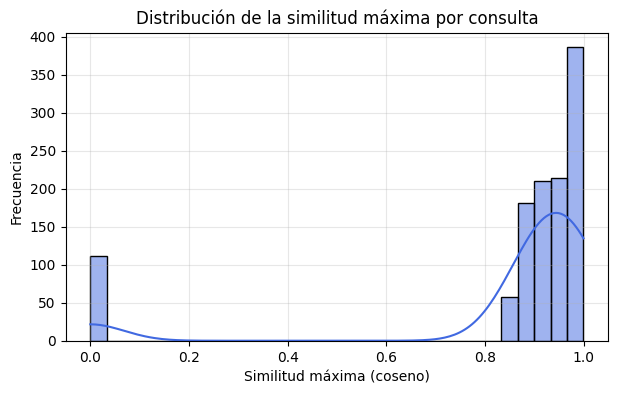

In [ ]:
plt.figure(figsize=(7,4))
sns.histplot(df_resultados["similitud_maxima"], bins=30, kde=True, color="royalblue")
plt.title("Distribución de la similitud máxima por consulta")
plt.xlabel("Similitud máxima (coseno)")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
plt.savefig("/content/drive/MyDrive/Proyecto MediSyncMatch Monografia/FigurasFrecuencia de la similitudMaxV2.png", dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

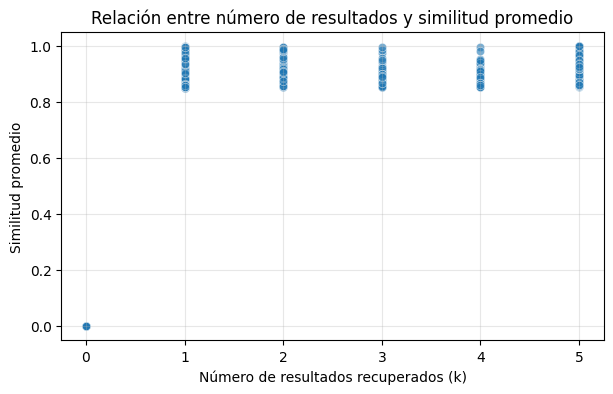

In [ ]:
plt.figure(figsize=(7,4))
sns.scatterplot(
    data=df_resultados,
    x="num_resultados",
    y="similitud_promedio",
    alpha=0.6
)
plt.title("Relación entre número de resultados y similitud promedio")
plt.xlabel("Número de resultados recuperados (k)")
plt.ylabel("Similitud promedio")
plt.grid(alpha=0.3)
plt.show()
